In [1]:
import pandas as pd
import numpy as np
import glob as glob
import os
import re
from rdkit.Chem import rdchem
from multiprocessing import Pool

import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0,'/global/homes/b/bpb/repos/carbon_network/blink')

import blink
# sys.path.insert(0,'/global/homes/b/bpb/repos/scndb/')
import build_tools as wt

In [2]:
# df = pd.read_csv('../data/public_and_internal_files_with_massive_and_redu.tsv', sep='\t')
# out_dir = '/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data'
#  /pscratch/sd/b/bpb/metatlas_mdm_parquet_files/global/cfs/cdirs/metatlas/raw_data/egsb/20230403_EB_BGS_107002-011_BIODESERT_Metagenome_EXP120A_C18-EP_USDAY72349

In [3]:
df = pd.read_csv('/global/cfs/cdirs/metatlas/projects/carbon_network/calibrated_parquet_files_with_metadata.tsv', sep='\t')
df = df[df['environmental']] #  | (idx2)
# df = df[df['SampleType']=='plant']
df

,parquet,h5,experiment_id,massive_id,redu_filename,files_per_experiment,title_massive,dataset_massive,description_massive,instrument_massive,...,termsofposition_redu,uberonontologyindex_redu,uniquesubjectid_redu,usi_redu,datasource_redu,environmental,num_unique_spectra,num_unique_formula,hash_value,fraction_within_half_tolerance
0,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000088823,MSV000088823,f.MSV000088823/updates/2022-02-16_bciap01_2e24...,864,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,MSV000088823,Interlab Study of LC-MS/MS analyis of Marine D...,MS:1001911;MS:1002523;MS:1001910;MS:1003112;MS...,...,NaN,NaN,NaN,NaN,NaN,True,1567.0,1330.0,2922127065080251723002354572150718387279650177...,1.000000
1,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000088823,MSV000088823,f.MSV000088823/updates/2022-02-16_bciap01_2e24...,864,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,MSV000088823,Interlab Study of LC-MS/MS analyis of Marine D...,MS:1001911;MS:1002523;MS:1001910;MS:1003112;MS...,...,NaN,NaN,NaN,NaN,NaN,True,268.0,244.0,5415988096707292882604959950879345231148750205...,1.000000
2,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000088823,MSV000088823,f.MSV000088823/updates/2022-02-16_bciap01_2e24...,864,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,MSV000088823,Interlab Study of LC-MS/MS analyis of Marine D...,MS:1001911;MS:1002523;MS:1001910;MS:1003112;MS...,...,NaN,NaN,NaN,NaN,NaN,True,414.0,373.0,1018451539903163137169146395494215476369431030...,0.999007
3,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000088823,MSV000088823,f.MSV000088823/updates/2022-02-16_bciap01_2e24...,864,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,MSV000088823,Interlab Study of LC-MS/MS analyis of Marine D...,MS:1001911;MS:1002523;MS:1001910;MS:1003112;MS...,...,NaN,NaN,NaN,NaN,NaN,True,30.0,30.0,1013762075614158948714126765969164481132430401...,1.000000
4,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000088823,MSV000088823,f.MSV000088823/updates/2022-02-16_bciap01_2e24...,864,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,MSV000088823,Interlab Study of LC-MS/MS analyis of Marine D...,MS:1001911;MS:1002523;MS:1001910;MS:1003112;MS...,...,NaN,NaN,NaN,NaN,NaN,True,962.0,657.0,7633415825185017833707972938015745417078694352...,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,SynDAC_20230223,NaN,NaN,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,374.0,296.0,9388980447530970871272038392163783433590616250...,1.000000
2004,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,FRCgw2_20230830,NaN,NaN,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,276.0,245.0,7691554974928442192395477242826347171018227719...,1.000000
2005,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,FRCgw2_20230830,NaN,NaN,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,441.0,357.0,2996053128748874369990133822326726924727652959...,1.000000
2006,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,DOM-TargetedMS2_pilot1,NaN,NaN,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,390.0,331.0,9739618844316565703298755352775119576894402083...,1.000000


In [4]:
# formula_df = pd.read_csv('/global/homes/b/bpb/repos/scndb/data/merged_fticr_formula (2).csv')
# formula_df.drop(columns=['Unnamed: 0'], inplace=True)
# # Add new columns for each unique value in "environment type"
# # cols = ['formula','environment_type']
# # formula_df = pd.pivot_table(formula_df[cols], index='formula', columns='environment_type', aggfunc=lambda x: True, fill_value=False)
# cols =  ['environment_type', 'extraction_solvent',
#        'ppl_extracted', 'instrument_type',
#        'mass_range', 'doi']
# for c in cols:
#     env = formula_df.groupby(['formula',c])['polarity'].count().unstack().fillna(0)
#     env[env>0] = 1
#     env.columns = ['%s:%s'%(c,x) for x in env.columns]
#     env = env.astype(int)
#     formula_df = formula_df.merge(env, left_on='formula', right_index=True)
#     formula_df.drop(columns=c, inplace=True)
#     print(c)
# formula_df.drop_duplicates(subset='formula', inplace=True)
# formula_df.reset_index(drop=True, inplace=True)

# formula_df.drop(columns=['mz','ionization_method','polarity'],inplace=True)

# formula_df

environment_type
extraction_solvent
ppl_extracted
instrument_type
mass_range
doi


,formula,environment_type:aquatic,environment_type:soil,environment_type:wetland,extraction_solvent:chloroform,extraction_solvent:methanol-water,extraction_solvent:water,ppl_extracted:False,ppl_extracted:True,instrument_type:12 Tesla FT-ICR-MS,instrument_type:15 Tesla FT-ICR-MS,mass_range:100-900,mass_range:125-2000,mass_range:150-2000,mass_range:200-1200,doi:https://doi.org/10.1016/j.gca.2021.10.018,doi:https://doi.org/10.1038/s41467-018-05665-9,doi:https://doi.org/10.1371/journal.pone.0119188,doi:https://doi.org/10.5194/bg-16-3911-2019
0,C6H5NO4,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0
1,C6H4O5,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0
2,C6H6O5,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0
3,C6H8O5,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0
4,C10H8O2,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15783,C20H19N1O11,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0
15784,C19H19N1O12,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0
15785,C20H19N1O12,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0
15786,C28H22O17,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0


In [5]:
# df = df[df['buddy_completed']]

In [6]:
# sample_info = pd.read_csv('../data/all_sampleinformation.tsv', sep='\t')
# sample_info.head()
# sample_info['basename'] = sample_info['filename'].apply(lambda x: os.path.basename(x))
# df['basename'] = df['mzml'].apply(lambda x: os.path.basename(x))

# df = pd.merge(df,sample_info, left_on='basename', right_on='basename',how='left')



In [7]:
import hashlib
import pandas as pd
import multiprocessing

def hash_dataframe_row(filename):
    cols = ['precursor_mz', 'rt', 'coisolated_precursor_count', 'predicted_formula', 'estimated_fdr']
    try:
        t = pd.read_parquet(filename)
        hash_value = int(hashlib.sha256(pd.util.hash_pandas_object(t[cols], index=True).values).hexdigest(), 16)
        return hash_value
    except:
        print('Error',filename)
        return None
    
def process_row(row):
    row = row[-1]
    temp = pd.read_parquet(row['parquet'])
    if temp.shape[0]>0:
        hash_value = hash_dataframe_row(row['parquet'])
        temp['parquet'] = row['parquet']
        return temp

with Pool(20) as pool:
    all_df = pool.map(process_row, df.iterrows())

all_df = [o for o in all_df if o is not None]
all_df = pd.concat(all_df)
all_df.reset_index(inplace=True,drop=True)
print(all_df.shape)
all_df = pd.merge(df, all_df, on='parquet',how='inner')
print(all_df.shape)
# df = pd.concat([df, out], axis=1)
all_df.reset_index(inplace=True,drop=True)
all_df.index.name = 'original_index'
all_df.reset_index(inplace=True,drop=False)

all_df

(887059, 14)
(887059, 66)


,original_index,parquet,h5,experiment_id,massive_id,redu_filename,files_per_experiment,title_massive,dataset_massive,description_massive,...,filename,coisolated_precursor_count,mdm_mz_vals,mdm_i_vals,original_mz_vals,original_i_vals,predicted_formula,estimated_fdr,ms2_mz_vals,ms2_i_vals
0,0,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000088823,MSV000088823,f.MSV000088823/updates/2022-02-16_bciap01_2e24...,864,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,MSV000088823,Interlab Study of LC-MS/MS analyis of Marine D...,...,/pscratch/sd/b/bpb/massive/v04/MSV000088823/up...,1,"[111.08161926269531, 129.09226989746094, 155.0...","[10721465.0, 656960.5625, 56297.25]","[136.58860778808594, 111.14517211914062, 111.7...","[14613.318359375, 140141.578125, 18139.5761718...",C8H14O4,0.000000,NaN,NaN
1,1,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000088823,MSV000088823,f.MSV000088823/updates/2022-02-16_bciap01_2e24...,864,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,MSV000088823,Interlab Study of LC-MS/MS analyis of Marine D...,...,/pscratch/sd/b/bpb/massive/v04/MSV000088823/up...,1,"[125.0973129272461, 143.10801696777344, 169.08...","[9762908.0, 227528.5, 317414.90625]","[143.10801696777344, 126.10077667236328, 125.1...","[227528.5, 30968.73046875, 66824.34375, 10057....",C9H16O4,0.000000,NaN,NaN
2,2,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000088823,MSV000088823,f.MSV000088823/updates/2022-02-16_bciap01_2e24...,864,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,MSV000088823,Interlab Study of LC-MS/MS analyis of Marine D...,...,/pscratch/sd/b/bpb/massive/v04/MSV000088823/up...,1,"[97.06599426269531, 111.08194732666016, 129.09...","[7082600.0, 28277.291015625, 60962.609375, 441...","[151.81387329101562, 128.9398193359375, 129.09...","[7604.35546875, 9653.4130859375, 60962.609375,...",C8H14O4,0.000000,NaN,NaN
3,3,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000088823,MSV000088823,f.MSV000088823/updates/2022-02-16_bciap01_2e24...,864,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,MSV000088823,Interlab Study of LC-MS/MS analyis of Marine D...,...,/pscratch/sd/b/bpb/massive/v04/MSV000088823/up...,2,"[77.03977966308594, 93.03470611572266, 121.029...","[27772.326171875, 163091.8125, 6207805.5, 1438...","[122.03307342529297, 137.02455139160156, 138.7...","[45360.1171875, 14380.583984375, 10332.6933593...",C8H6O4,0.000000,NaN,NaN
4,4,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000088823,MSV000088823,f.MSV000088823/updates/2022-02-16_bciap01_2e24...,864,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,MSV000088823,Interlab Study of LC-MS/MS analyis of Marine D...,...,/pscratch/sd/b/bpb/massive/v04/MSV000088823/up...,2,"[121.02962493896484, 121.06614685058594, 137.0...","[6207805.5, 32377.93359375, 14380.583984375]","[122.03307342529297, 137.02455139160156, 138.7...","[45360.1171875, 14380.583984375, 10332.6933593...",C9H10O3,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887054,887054,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,CenturyExpPilot_20230414,NaN,NaN,1,NaN,NaN,NaN,...,/global/cfs/cdirs/metatlas/projects/rawdata_fo...,4,"[207.08123779296875, 235.0756072998047, 267.10...","[6393.5927734375, 12588.76953125, 8056.3056640...","[283.13482666015625, 281.1182556152344, 267.13...","[35006.5546875, 12811.0244140625, 15123.492187...",C20H16O9,0.001499,NaN,NaN
887055,887055,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,CenturyExpPilot_20230414,NaN,NaN,1,NaN,NaN,NaN,...,/global/cfs/cdirs/metatlas/projects/rawdata_fo...,2,"[175.11355590820312, 191.10842895507812, 219.1...","[9521.853515625, 5376.2958984375, 10744.536132...","[195.1017608642578, 197.0609893798828, 209.118...","[8795.9482421875, 18198.171875, 9511.381835937...",C13H16O6S,0.000023,NaN,NaN
887056,887056,/global/cfs/cdirs/metatlas/projects/carbo

In [8]:
all_df.shape

(887059, 67)

In [9]:
mz_tol = 0.002
deltas = pd.read_csv('/global/cfs/cdirs/metatlas/projects/carbon_network/mdm_neutral_losses.csv')
ref,ref2 = wt.get_p2d2(deltas,mz_tol=mz_tol)
print(ref.shape)
# ref = ref[ref['formula'].isin(formula_df['formula'])]
ref.reset_index(inplace=True,drop=True)
# ref2 = ref2[ref2['formula'].isin(formula_df['formula'])]
ref2.reset_index(inplace=True,drop=True)
print(ref.shape)
ref_spec = ref['spectrum'].tolist()
ref_pmz = ref['precursor_mz'].tolist()

ref_spec_nl = ref2['nl_spectrum'].tolist()
ref_pmz_nl = ref2['precursor_mz'].tolist()

def score_df(df):
    min_matches=3,
    min_score=0.7,
    override_matches=20

    
    q_cols = ['predicted_formula','precursor_mz']
    r_cols = ['original_p2d2_index', 'formula','precursor_mz', 'inchi_key','name']
    # q = q[q['predicted_formula'].isin(ref['formula'])].copy()
    # q = query.head(10000)
    if df.shape[0]==0:
        return None
    if 'mdm_mz_vals' not in df.columns:
        return None
    df['num_mdm_frags'] = df['mdm_mz_vals'].apply(lambda x: len(x) if type(x)!=float else 0)

    df = df[df['num_mdm_frags']>0]
    df.reset_index(inplace=True,drop=True)
    df.index.name = 'original_index'
    df.reset_index(inplace=True,drop=False)

    df['nl_spectrum'] = df.apply(lambda x: np.asarray([x['mdm_mz_vals'],x['mdm_i_vals']]),axis=1)
    df['original_spectrum'] = df.apply(lambda x: np.asarray([x['original_mz_vals'],x['original_i_vals']]),axis=1)

    query_spec = df['original_spectrum'].tolist()
    query_pmz = df['precursor_mz'].tolist()
    query_spec_nl = df['nl_spectrum'].tolist()
    query_pmz_nl = df['precursor_mz'].tolist()

    d_specs = blink.discretize_spectra(query_spec,  ref_spec, query_pmz, ref_pmz, intensity_power=0.5, bin_width=0.001, tolerance=0.01,network_score=False)#,mass_diffs=mass_diffs)
    d_specs_nl = blink.discretize_spectra(query_spec_nl,  ref_spec_nl, query_pmz_nl, ref_pmz_nl, intensity_power=0.5, bin_width=0.001, tolerance=0.01,network_score=False)#,mass_diffs=mass_diffs)
    
    def score_and_filter(specs,r,q,mz_tol=0.002,min_score=0.7,min_matches=3,override_matches=20,
                         q_cols=['predicted_formula','precursor_mz'],
                         r_cols=['original_p2d2_index', 'formula','precursor_mz', 'inchi_key','name']):
        scores = blink.score_sparse_spectra(specs)
        filtered_scores = blink.filter_hits(scores,min_score=min_score,min_matches=min_matches,override_matches=override_matches,)
        mz_df = blink.reformat_score_matrix(filtered_scores)
        mz_df = blink.make_output_df(mz_df)
        for c in mz_df.columns:
            mz_df[c] = mz_df[c].sparse.to_dense()

        mz_df = pd.merge(mz_df,q[q_cols],left_on='query',right_index=True)
        mz_df = pd.merge(mz_df,r[r_cols].add_suffix('_ref'),left_on='ref',right_index=True)
        # mz_df = mz_df[mz_df['predicted_formula']==mz_df['formula']]
        mz_df = mz_df[abs(mz_df['precursor_mz']-mz_df['precursor_mz_ref'])<mz_tol]
        # mz_df.sort_values('score',ascending=False,inplace=True)
        # mz_df.drop_duplicates('inchi_key_ref',keep='first',inplace=True)
        return mz_df
    orig_hits = score_and_filter(d_specs,ref,df,mz_tol=mz_tol,min_score=0.7,min_matches=3,override_matches=20,
                             q_cols=['predicted_formula','precursor_mz'],
                             r_cols=['original_p2d2_index', 'formula','precursor_mz', 'inchi_key','name'])
    nl_hits = score_and_filter(d_specs_nl,ref2,df,mz_tol=mz_tol,min_score=0.7,min_matches=3,override_matches=20,
                             q_cols=['predicted_formula','precursor_mz'],
                             r_cols=['original_p2d2_index', 'formula','precursor_mz', 'inchi_key','name'])
    temp = pd.merge(nl_hits,orig_hits,on=['query','original_p2d2_index_ref'],how='outer',suffixes=('_original','_nl'))
    if temp.shape[0]==0:
        return None
    temp['max_score'] = temp[['score_original','score_nl']].max(axis=1)
    temp['best_match_method'] = temp[['score_original','score_nl']].idxmax(axis=1)
    temp.sort_values('max_score',ascending=False,inplace=True)
    temp = temp[temp['max_score']>min_score]  #filter on score
    temp['max_matches'] = 0
    idx = temp['best_match_method']=='score_original'
    temp.loc[idx,'max_matches'] = temp.loc[idx,'matches_original']
    idx = temp['best_match_method']=='score_nl'
    temp.loc[idx,'max_matches'] = temp.loc[idx,'matches_nl']
    temp = temp[temp['max_matches']>=min_matches]  #filter on matches


    cols = ['score_original','matches_original', 'score_nl', 'matches_nl']
    temp.drop(columns=cols,inplace=True)
    temp = pd.merge(temp,df[['original_index','precursor_mz','coisolated_precursor_count']].add_suffix('_query'),left_on='query',right_index=True)

    idx_isolated = (temp['coisolated_precursor_count_query']>1) & (temp['best_match_method']=='score_original')
    temp = temp[~idx_isolated] #filter on isolated precursor

    cols = ['name', 'inchi_key', 'smiles','formula','precursor_mz','original_p2d2_index']
    temp = pd.merge(temp,ref[cols],left_on='original_p2d2_index_ref',right_on='original_p2d2_index',how='left')

    idx_precursor = (abs(temp['precursor_mz_query']-temp['precursor_mz'])<mz_tol)
    temp = temp[idx_precursor] #filter on precursor m/z

    temp.sort_values('max_score',ascending=False,inplace=True)

    temp = temp.groupby('query').head(1)
    temp.reset_index(inplace=True,drop=True)
    
    df = pd.merge(df,temp.add_suffix('_identity'),left_on='original_index',right_on='original_index_query_identity',how='left')
    # df.drop(columns=['original_index_query_analog','original_p2d2_index','query'],inplace=True)

    cols = ['original_index_query_identity',
            'query_identity',
            'precursor_mz_query_identity',
            'coisolated_precursor_count_query_identity']
    df.drop(columns=cols,inplace=True)
    df.sort_values('max_score_identity',ascending=False,inplace=True)
    df.drop_duplicates('inchi_key_identity',keep='first',inplace=True)
    df = df[df['max_score_identity']>0]
    if df.shape[0]==0:
        return None
    return df







def process_row(parquet_file):
    temp = pd.read_parquet(parquet_file)
    if temp.shape[0]>0:
        temp = score_df(temp)
        if temp is not None:
            temp['parquet'] = parquet_file
            return temp
    

files = df[pd.notna(df['parquet'])]['parquet'].tolist()
with Pool(20) as pool:
    out = pool.map(process_row, files)

out = [o for o in out if o is not None]
out = pd.concat(out)
out.reset_index(inplace=True,drop=True)
df = pd.merge(df, out, on='parquet', how='outer')
# df = pd.concat([df, out], axis=1)
df.reset_index(inplace=True,drop=True)
# df.index.name = 'original_index'
# df.reset_index(inplace=True,drop=False)
# df
# out = process_row([0,df.loc[9667]])
# out = out[out['formula'].isin(formula_df['formula'])]
df

(25677, 9)
(25677, 9)


,parquet,h5,experiment_id,massive_id,redu_filename,files_per_experiment,title_massive,dataset_massive,description_massive,instrument_massive,...,name_ref_nl_identity,max_score_identity,best_match_method_identity,max_matches_identity,name_identity,inchi_key_identity,smiles_identity,formula_identity,precursor_mz_identity,original_p2d2_index_identity
0,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000088823,MSV000088823,f.MSV000088823/updates/2022-02-16_bciap01_2e24...,864,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,MSV000088823,Interlab Study of LC-MS/MS analyis of Marine D...,MS:1001911;MS:1002523;MS:1001910;MS:1003112;MS...,...,Octanedioic acid,0.999877,score_original,3.0,Octanedioic acid,TYFQFVWCELRYAO-UHFFFAOYSA-N,O=C(O)CCCCCCC(=O)O,C8H14O4,173.082000,116.0
1,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000088823,MSV000088823,f.MSV000088823/updates/2022-02-16_bciap01_2e24...,864,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,MSV000088823,Interlab Study of LC-MS/MS analyis of Marine D...,MS:1001911;MS:1002523;MS:1001910;MS:1003112;MS...,...,azelaic acid,0.999560,score_original,3.0,azelaic acid,BDJRBEYXGGNYIS-UHFFFAOYSA-N,O=C(O)CCCCCCCC(=O)O,C9H16O4,187.097559,4292.0
2,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000088823,MSV000088823,f.MSV000088823/updates/2022-02-16_bciap01_2e24...,864,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,MSV000088823,Interlab Study of LC-MS/MS analyis of Marine D...,MS:1001911;MS:1002523;MS:1001910;MS:1003112;MS...,...,pimelic acid,0.998795,score_original,4.0,pimelic acid,WLJVNTCWHIRURA-UHFFFAOYSA-N,O=C(O)CCCCCC(=O)O,C7H12O4,159.066259,5458.0
3,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000088823,MSV000088823,f.MSV000088823/updates/2022-02-16_bciap01_2e24...,864,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,MSV000088823,Interlab Study of LC-MS/MS analyis of Marine D...,MS:1001911;MS:1002523;MS:1001910;MS:1003112;MS...,...,NaN,0.987528,score_original,3.0,DODECANEDIOIC ACID,TVIDDXQYHWJXFK-UHFFFAOYSA-N,O=C(O)CCCCCCCCCCC(=O)O,C12H22O4,229.144500,116422.0
4,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000088823,MSV000088823,f.MSV000088823/updates/2022-02-16_bciap01_2e24...,864,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,MSV000088823,Interlab Study of LC-MS/MS analyis of Marine D...,MS:1001911;MS:1002523;MS:1001910;MS:1003112;MS...,...,NaN,0.984593,score_original,3.0,TRIDECANEDIOIC ACID,DXNCZXXFRKPEPY-UHFFFAOYSA-N,O=C(O)CCCCCCCCCCCC(=O)O,C13H24O4,243.160200,100612.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47396,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,CenturyExpPilot_20230414,NaN,NaN,1,NaN,NaN,NaN,NaN,...,"3,11,20-Trihydroxypregn-8-ene-4-carboxylic acid",0.762178,score_nl,8.0,"3,11,20-Trihydroxypregn-8-ene-4-carboxylic acid",ZHDGKAOGMGOSPM-UHFFFAOYSA-N,CC(O)C1CCC2C3=C(C(O)CC21C)C1(C)CCC(O)C(C(=O)O)...,C22H34O5,377.233300,122550.0
47397,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,CenturyExpPilot_20230414,NaN,NaN,1,NaN,NaN,NaN,NaN,...,"3-Hydroxylup-20(29)-ene-23,27,28-trioic acid",0.751963,score_nl,3.0,"3-Hydroxylup-20(29)-ene-23,27,28-trioic acid",FTGKHGAVFGGOMW-UHFFFAOYSA-N,C=C(C)C1CCC2(C(=O)O)CCC3(C(=O)O)C(CCC4C5(C)CCC...,C30H44O7,515.301400,101578.0
47398,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,CenturyExpPilot_20230414,NaN,NaN,1,NaN,NaN,NaN,NaN,...,Dinor-12-oxophytodienoic Acid,0.751594,score_nl,4.0,Dinor-12-oxophytodienoic Acid,SZVNKXCDJUBPQO-DWMAKUKJSA-N,CC/C=C\C[C@@H]1C(=O)C=C[C@@H]1CCCCCC(=O)O,C16H24O3,263.165300,116338.0
47399,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,CenturyExpPilot_20230414,NaN,NaN,1,NaN,NaN,NaN,NaN,...,"8,8-Dimethyl-2-oxooctahydro-3a,7-ethanoindene-...",0.742885,score_nl,6.0,"8,8-Dimethyl-2-oxooctahydro-3a,7-ethanoinde

In [10]:
# df.sort_values('max_score_identity',ascending=False,inplace=True)
# df.drop_duplicates('inchi_key_identity',keep='first',inplace=True)
# # out['best_match_method_identity'].value_counts()
# idx = out['formula_identity'].isin(formula_df['formula'])
# out.loc[idx,'inchi_key_identity'].nunique()

In [11]:
# df['num_mdm_frags'] = df['mdm_mz_vals'].apply(lambda x: len(x) if type(x)!=float else 0)

# df = df[df['num_mdm_frags']>0]

In [12]:
# temp = pd.merge(df,formula_df,left_on='formula_identity',right_on='formula',how='left')
# df['isin_fticr_formula'] = df['formula_identity'].isin(formula_df['formula'])
# print(len(df.loc[df['isin_fticr_formula'],'predicted_formula'].unique()),len(df['predicted_formula'].unique()),len(formula_df['formula'].unique()))

In [13]:

# # df = df[df['isin_fticr_formula']]
# df['nl_spectrum'] = df.apply(lambda x: np.asarray([x['mdm_mz_vals'],x['mdm_i_vals']]),axis=1)
# df['original_spectrum'] = df.apply(lambda x: np.asarray([x['original_mz_vals'],x['original_i_vals']]),axis=1)
# # print(len(df.loc[df['isin_fticr_formula'],'predicted_formula'].unique()),len(df['predicted_formula'].unique()),len(formula_df['formula'].unique()))



In [14]:
# out = score_df(df.sample(10000))
# out

In [15]:
# mz_tol = 0.002
# deltas = pd.read_csv('../data/mdm_neutral_losses.csv')
# ref,ref2 = wt.get_p2d2(deltas,mz_tol=mz_tol)
# ref = ref[ref['formula'].isin(df['predicted_formula'])]
# ref2 = ref2[ref2['formula'].isin(df['predicted_formula'])]
# ref = ref[ref['formula'].isin(formula_df['formula'])]
# ref2 = ref2[ref2['formula'].isin(formula_df['formula'])]



In [16]:
# idx = df['predicted_formula'].isin(ref['formula'])
# query_spec = df.loc[idx,'original_spectrum'].tolist()
# query_pmz = df.loc[idx,'precursor_mz'].tolist()
# idx = df['predicted_formula'].isin(ref2['formula'])
# query_spec_nl = df.loc[idx,'nl_spectrum'].tolist()
# query_pmz_nl = df.loc[idx,'precursor_mz'].tolist()

# ref_spec = ref['spectrum'].tolist()
# ref_pmz = ref['precursor_mz'].tolist()

# ref_spec_nl = ref2['nl_spectrum'].tolist()
# ref_pmz_nl = ref2['precursor_mz'].tolist()

# # polarity = 'negative'
# # # import pickle as pickle
# # from joblib import load

# # with open('/global/homes/b/bpb/repos/blink/models/{}_random_forest.joblib'.format(polarity), 'rb') as out:
# #     regressor = load(out)

# # mass_diffs = [0, 14.0157, 12.000, 15.9949, 2.01565, 27.9949, 26.0157, 18.0106, 30.0106, 42.0106, 1.9792, 17.00284, 24.000, 13.97925, 1.00794, 40.0313]#, 43.993]

# d_specs = blink.discretize_spectra(query_spec,  ref_spec, query_pmz, ref_pmz, intensity_power=0.5, bin_width=0.001, tolerance=0.01,network_score=False)#,mass_diffs=mass_diffs)
# d_specs_nl = blink.discretize_spectra(query_spec_nl,  ref_spec_nl, query_pmz_nl, ref_pmz_nl, intensity_power=0.5, bin_width=0.001, tolerance=0.01,network_score=False)#,mass_diffs=mass_diffs)

In [17]:
# print(df.shape)
# df = df[~df['predicted_formula'].str.contains('P|N|S')]
# print(df.shape)
# print(len(df.loc[df['isin_fticr_formula'],'predicted_formula'].unique()),len(df['predicted_formula'].unique()),len(formula_df['formula'].unique()))


In [127]:

# def filter_assets(df,group_term='parquet'):
#     df = df[pd.notna(df['formula_identity'])]
#     result_true = df[df['isin_fticr_formula'] == True].groupby(group_term)['formula_identity'].nunique()
#     result_false = df[df['isin_fticr_formula'] == False].groupby(group_term)['formula_identity'].nunique()
#     combined_result = pd.concat([result_true, result_false], axis=1)
#     combined_result.columns = ['result_true', 'result_false']

#     combined_result.fillna(0, inplace=True)
#     combined_result['fraction_true'] = combined_result['result_true'] / (combined_result['result_true'] + combined_result['result_false'])
#     combined_result.reset_index(inplace=True,drop=False)
#     # Extract the 'fraction_true' values
#     fraction_true_values = combined_result['fraction_true'].values.reshape(-1, 1)

#     # Fit a Gaussian Mixture Model with 2 components
#     gmm = GaussianMixture(n_components=2, means_init=np.array([[0.3], [0.7]]))
#     gmm.fit(fraction_true_values)

#     # Get the means of the two Gaussian distributions
#     means = gmm.means_

#     # Print the means
#     print("Mean of the first Gaussian distribution:", means[0][0])
#     print("Mean of the second Gaussian distribution:", means[1][0])

#     cluster_labels = gmm.predict(fraction_true_values)

#     # Separate the two populations based on the cluster labels
#     population1 = fraction_true_values[cluster_labels == 0]
#     population2 = fraction_true_values[cluster_labels == 1]
#     min_val = fraction_true_values[cluster_labels == 1].min()
#     print("Minimum value of the higher distribution:", fraction_true_values[cluster_labels == 1].min())



#     # Plot the two populations
#     plt.hist(population1, bins=np.linspace(0,1,30), alpha=0.5, label='Population 1')
#     plt.hist(population2, bins=np.linspace(0,1,30), alpha=0.5, label='Population 2')
#     plt.xlabel('fraction_true')
#     plt.ylabel('Count')
#     plt.legend()
#     plt.show()


#     good_files = combined_result.loc[combined_result['fraction_true'] > min_val, 'parquet'].tolist()
    
#     return good_files

# good_files = filter_assets(df)
# print(df.shape, len(good_files),len(df['parquet'].unique()))
# df = df[df['parquet'].isin(good_files)]
# print(df.shape, len(good_files),len(df['parquet'].unique()))

In [19]:
# unique_massive_ids = df.groupby('formula_identity')['massive_id'].nunique()
# unique_massive_ids = unique_massive_ids[unique_massive_ids>1]
# # fig,ax = plt.subplots()
# # ax.hist(unique_massive_ids,bins=100)
# # unique_massive_ids
# # ax.set_yscale('log')
# # ax.set_xscale('log')
# # plt.show()
# df = df[df['predicted_formula'].isin(unique_massive_ids.index)]

In [20]:
# result_true = df[df['isin_fticr_formula'] == True].groupby('buddy')['predicted_formula'].nunique()
# result_false = df[df['isin_fticr_formula'] == False].groupby('buddy')['predicted_formula'].nunique()
# combined_result = pd.concat([result_true, result_false], axis=1)
# combined_result.columns = ['result_true', 'result_false']

# combined_result.fillna(0, inplace=True)
# combined_result.reset_index(inplace=True,drop=False)

# # combined_result = combined_result[combined_result['result_true'] + combined_result['result_false'] > 1000]
# combined_result = combined_result[combined_result['buddy'].str.contains('MSV000088823')]
# combined_result['buddy'] = combined_result['buddy'].apply(lambda x: os.path.basename(x).replace('.parquet','').replace('DOM_Interlab-LCMS_',''))
# combined_result.sort_values('result_true',ascending=True,inplace=True)
# combined_result['fraction_true'] = combined_result['result_true'] / (combined_result['result_true'] + combined_result['result_false'])
# combined_result.reset_index(inplace=True)
# import matplotlib.pyplot as plt
# fig,ax = plt.subplots(figsize=(18,8))
# combined_result.plot(x='buddy', y=['result_true', 'result_false'], kind='bar',ax=ax,stacked=True)
# # plt.xlabel('Massive ID')
# ax.set_ylabel('Number of Unique Predicted Formulas')
# # plt.title('Number of Unique Predicted Formulas by Massive ID')
# plt.legend(['In FTICR', 'Not In FTICR'])
# plt.tight_layout()
# # combined_result.plot(x='massive_id', y=['result_true', 'result_false'], kind='bar', ax=ax, stacked=True)

# # Add "*" above bars with 'fraction_true' less than 0.2
# for i, row in combined_result.iterrows():
#     if row['fraction_true'] < 0.20:
#         ax.text(i, 1.00*(row['result_true'] + row['result_false']), "*", ha='center', va='bottom',fontsize=24)
#         # ax.text(i,1,'*')

# ax.set_ylabel('Number of Unique Predicted Formulas')
# plt.legend(['In FTICR', 'Not In FTICR'])
# plt.tight_layout()

# plt.show()


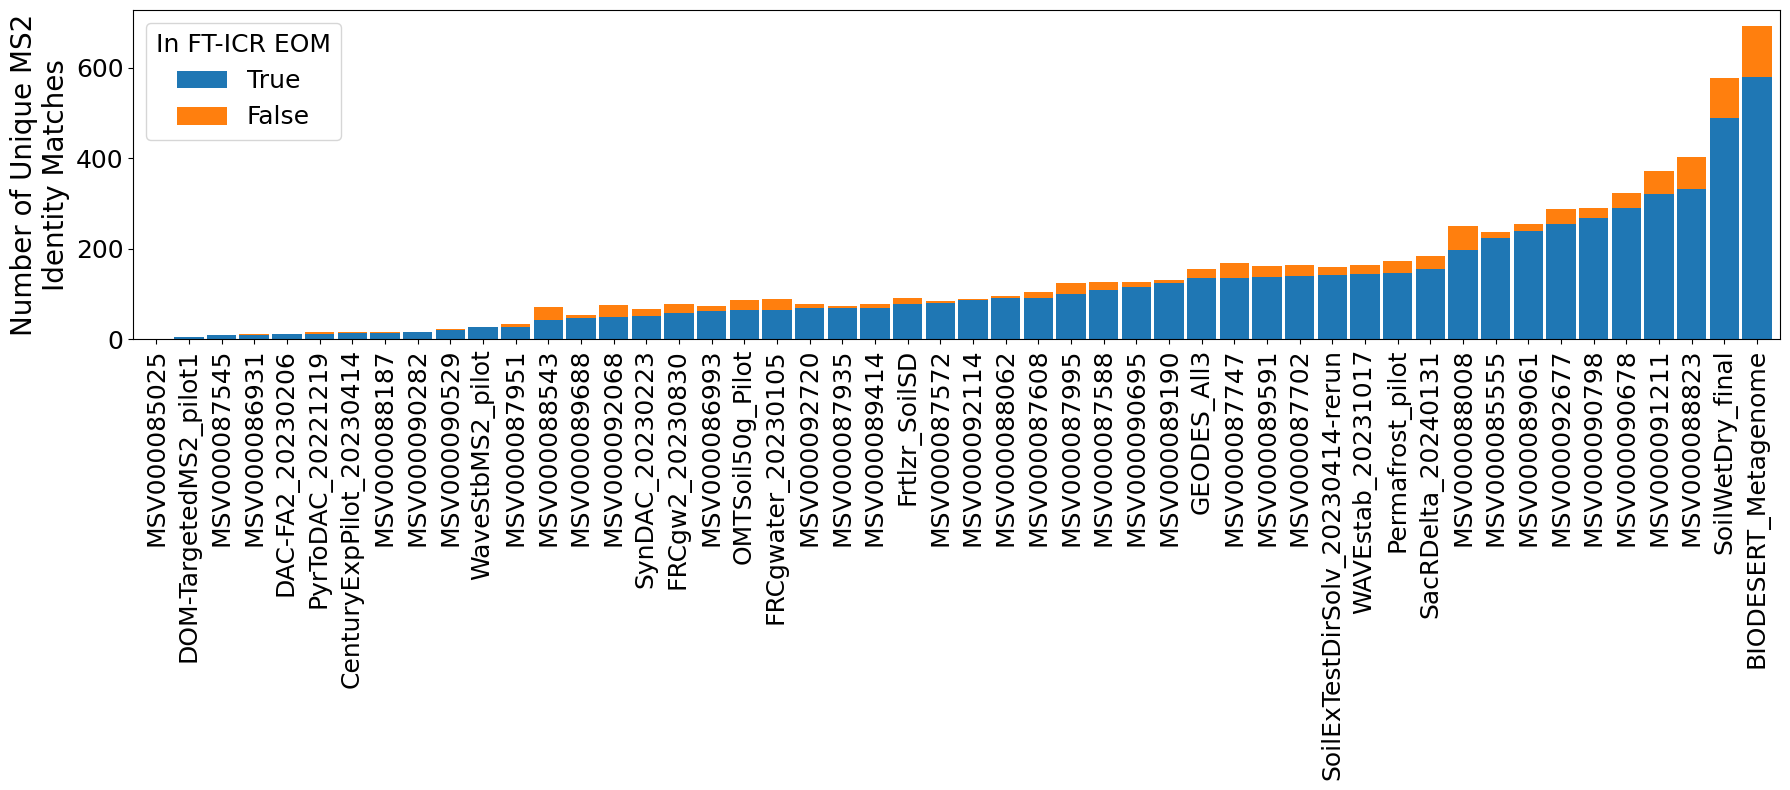

In [21]:
# temp = df[pd.notna(df['formula_identity'])]
# k = 'inchi_key_identity'
# # k = 'formula_identity'
# result_true = temp[temp['isin_fticr_formula'] == True].groupby('experiment_id')[k].nunique()
# result_false = temp[temp['isin_fticr_formula'] == False].groupby('experiment_id')[k].nunique()
# combined_result = pd.concat([result_true, result_false], axis=1)
# combined_result.columns = ['result_true', 'result_false']
# combined_result.fillna(0, inplace=True)

# combined_result.sort_values('result_true',ascending=True,inplace=True)
# combined_result['fraction_true'] = combined_result['result_true'] / (combined_result['result_true'] + combined_result['result_false'])
# combined_result.reset_index(inplace=True)
# import matplotlib.pyplot as plt
# fig,ax = plt.subplots(figsize=(18,8))
# combined_result.plot(x='experiment_id', y=['result_true', 'result_false'], kind='bar',width=0.9,ax=ax,stacked=True)
# # plt.xlabel('Massive ID')



# # Add "*" above bars with 'fraction_true' less than 0.2
# for i, row in combined_result.iterrows():
#     if row['fraction_true'] < 0.20:
#         ax.text(i, 1.00*(row['result_true'] + row['result_false']), "*", ha='center', va='bottom',fontsize=24)
#         # ax.text(i,1,'*')

# ax.set_ylabel('Number of Unique MS2\nIdentity Matches',fontsize=20)
# ax.set_xlabel('')
# ax.tick_params(axis='x', labelsize=18)
# ax.tick_params(axis='y', labelsize=18)

# plt.legend(['True', 'False'],title='In FT-ICR EOM',fontsize=18,title_fontsize=18)
# plt.tight_layout()

# plt.show()


In [22]:
hits_df = df.copy()
hits_df.sort_values('max_score_identity',ascending=False,inplace=True)
hits_df.drop_duplicates('inchi_key_identity',keep='first',inplace=True)

In [23]:
hits_df.to_pickle('/global/cfs/cdirs/metatlas/projects/carbon_network/top_scoring_inchikey.pkl')

In [24]:
filtered_spectra = all_df[all_df['parquet'].isin(df['parquet'])]
filtered_spectra.reset_index(inplace=True,drop=True)
filtered_spectra.to_pickle('/global/cfs/cdirs/metatlas/projects/carbon_network/all_spectra_backup.pkl')


In [126]:
hits_df['parquet'].nunique()

681

In [125]:
filtered_spectra['parquet'].nunique()

1452

# stop here????

In [25]:
# df = pd.read_pickle('top_scoring_inchikey.pkl')
# all_df = pd.read_pickle('/global/cfs/cdirs/metatlas/projects/spectral_libraries/temp_backup.pkl')

# # df = pd.read_pickle('top_scoring_inchikey_lbl.pkl')
# # all_df = pd.read_pickle('/global/cfs/cdirs/metatlas/projects/spectral_libraries/temp_backup_lbl.pkl')

# all_df['nl_spectrum'] = all_df.apply(lambda x: np.asarray([x['mdm_mz_vals'],x['mdm_i_vals']]),axis=1)

# all_df['sum_frag_intensity'] = all_df['mdm_i_vals'].apply(lambda x: np.sum(x))
# all_df['original_spectrum'] = all_df['nl_spectrum']#df.apply(lambda x: np.asarray([x['original_mz_vals'],x['original_i_vals']]),axis=1)
# all_df = all_df[all_df['sum_frag_intensity']>0]
# all_df = all_df[pd.notna(all_df['predicted_formula'])]
# all_df = all_df[all_df['massive_id'].isin(df['massive_id'])]
# df['num_mdm_frags'] = df['mdm_mz_vals'].apply(lambda x: len(x))
# all_df

In [26]:
# print(all_df.shape)
# all_df = all_df[~all_df['predicted_formula'].isin(df['predicted_formula'])]
# print(all_df.shape)

In [27]:
# mz_tol = 0.002
# similarity_cutoff = 0.2
# isolation_tol = 0.5
# min_intensity_ratio = 2 #minimum intensity ratio between sum of fragments between two spectra
# my_polarity = 'negative' #either 'positive' or 'negative'

# deltas = pd.read_csv('../data/mdm_neutral_losses.csv')

# all_df['round3_precursor_mz'] = all_df['precursor_mz'].round(3)
# g = all_df.groupby('round3_precursor_mz')
# # g = all_df.groupby('predicted_formula')
# gg = [g.get_group(x) for x in g.groups]

# out = []
# for ggg in gg:
#     if ggg.shape[0]>1:
#         temp = wt.eliminate_duplicate_spectra(ggg,deltas,mz_tol=mz_tol,
#                                 similarity_cutoff=similarity_cutoff,
#                                 min_intensity_ratio=min_intensity_ratio)
#         out.append(temp)
#         # print(temp.shape[0],ggg.shape[0])
#     else:
#         out.append(ggg)
        
# out = pd.concat(out)
# out.reset_index(inplace=True,drop=True)
# out


In [28]:
# from importlib import reload
# reload(wt)

In [29]:
# out = wt.eliminate_duplicate_spectra(out,deltas,mz_tol=mz_tol,
#                                 similarity_cutoff=similarity_cutoff,
#                                 min_intensity_ratio=min_intensity_ratio)
# out.reset_index(inplace=True,drop=True)
# out.shape[0]

In [30]:
#18437 using formula nuclear option. 18813 without.

In [31]:
# df.reset_index(inplace=True,drop=True)
# out.reset_index(inplace=True,drop=True)
# temp = pd.concat([df,out],axis=0)
# temp.reset_index(inplace=True,drop=True)
# mass_diffs = [0] + deltas['mass'].tolist()
# rem_df = wt.do_remblink_networking(temp,temp,mass_diffs=mass_diffs,
#                                    spectra_attr='nl_spectrum')
# # rem_df = wt.do_remblink_networking(out,df,spectra_attr='nl_spectrum')
# cols = ['ref','query','rem_predicted_score']
# rem_df = rem_df[cols]
# print(rem_df.shape)
# rem_df = rem_df[rem_df['rem_predicted_score']>0.1]
# print(rem_df.shape)

In [32]:
# if 'original_index' in temp.columns:
#     temp.drop(columns=['original_index'],inplace=True)
# temp.index.name = 'original_index'
# temp.reset_index(inplace=True,drop=False)


In [33]:
# cols = ['original_index', 
#        'massive_id', 'no_extension_basename','title', 'description', 
#        'precursor_mz', 'isolated_precursor_mz', 'rt',
#        'coisolated_precursor_count', 'predicted_formula',
#        'estimated_fdr', 'predicted_mass', 'mass_error', 'num_mdm_frags',
#        'max_score_identity', 'best_match_method_identity',
#        'max_matches_identity', 'name_identity', 'inchi_key_identity',
#        'smiles_identity', 'formula_identity', 'precursor_mz_identity',
#        'original_p2d2_index_identity', 'isin_fticr_formula']

# # 'instrument', 'keywords', 'ChromatographyAndPhase',
# #        'YearOfAnalysis', 'SampleType', 'IonizationSourceAndPolarity',
# #        'SampleCollectionMethod', 'MassSpectrometer',
# #        'NCBITaxonomy', 'SampleExtractionMethod', 

In [34]:
# temp[cols]

In [35]:
# import networkx as nx
# # # Create the graph from the similarity matrix
# G = nx.from_pandas_edgelist(rem_df,source='ref',target='query',edge_attr='rem_predicted_score')
# # (similarity_matrix > similarity_cutoff)
# # # Add node data from ms2_df to G
# # cols = list(set([c for c in temp.columns if not 'spect' in c]) - set(['obs','coisolated_precursor_mz_list','mol','filename', 'basename', 'experiment']))
# # cols = [c for c in cols if not 'mdm_' in c]
# # cols = [c for c in cols if not 'original_' in c]
# # cols = [c for c in cols if not 'nl_' in c]

# # cols = cols + ['stable']
# node_data = temp[cols].fillna('').to_dict(orient='index')

# nx.set_node_attributes(G, node_data)

# # print(len(G.nodes))
# # print(len(G.edges))

# # # Remove self-loops
# G.remove_edges_from([(u, v) for u, v in G.edges() if u == v])         

# # Remove isolates
# G.remove_nodes_from(list(nx.isolates(G)))
# print('nodes',len(G.nodes))
# print('edges',len(G.edges))


In [36]:
# nx.write_graphml(G,'eom-net_0p1_new-rem-blink.graphml')

In [37]:
# max_weights = {}

# for node in G.nodes:
#     weights = [data['rem_predicted_score'] for _, _, data in G.edges(node, data=True)]
#     if weights:
#         max_weights[node] = max(weights)
#     else:
#         max_weights[node] = None  # or some other value indicating no connections

# weights = [v for k,v in max_weights.items() if v is not None]


In [38]:
# fig,ax = plt.subplots()
# ax.hist(weights,bins=100)
# # ax.set_xlim(0)
# # ax.set_yscale('log')
# plt.show()

In [39]:
# from blink.utils import filter_top_k, filter_component_additive
# filter_top_k(G,5,'rem_predicted_score')
# print('nodes',len(G.nodes))
# print('edges',len(G.edges))
# nx.write_graphml(G,'eom-net_0p1_new-rem-blink_k5.graphml')

In [40]:


# def compute_jaccard_bonds(row):
#     smiles0 = row[0]
#     smiles1 = row[1]

#     # if (isinstance(smiles0, str)) & (isinstance(smiles1, str)):
#     mol0 = MolFromSmiles(smiles0)
#     mol1 = MolFromSmiles(smiles1)

#     res = rdFMCS.FindMCS([mol0, mol1], timeout=10, ringMatchesRingOnly=True)
#     # else:
#         # return 0

#     A = mol0.GetNumBonds()
#     B = mol1.GetNumBonds()
#     # try to grab res.numBonds
#     if min([A,B])>0:
#         TP = res.numBonds
#         jaccard = TP / ((A+B) - TP)
#     else:
#         jaccard = 0
    
#     return jaccard

# def nodes_within_distance(source_node, graph, max_distance):
#     shortest_path_lengths = nx.single_source_shortest_path_length(graph, source_node)
#     nodes_within_distance = [node for node, distance in shortest_path_lengths.items() if distance <= max_distance]
#     return nodes_within_distance



In [41]:


# df = pd.read_pickle('top_scoring_inchikey.pkl')
# df.columns
# node_data = G.nodes(data=True)
# node_data = pd.DataFrame(node_data)
# node_data.columns = ['node','data']
# node_data['data'] = node_data['data'].apply(lambda x: dict(x))
# node_data = pd.concat([node_data.drop(['data'], axis=1), node_data['data'].apply(pd.Series)], axis=1)
# node_data.reset_index(inplace=True,drop=True)
# node_data = node_data[node_data['inchi_key_identity'].notna()]

# # pink_nodes = [2064.0,
# # 315.0,
# # 1420.0,
# # 598.0,
# # 495.0,
# # 536.0,
# # 625.0,
# # 623.0,
# # 507.0,
# # 266.0,
# # 445.0,
# # 1877.0,
# # 5612.0,
# # 755.0,
# # 2886.0]

# # green_nodes = [809.0,
# # 9314.0,
# # 7032.0,
# # 7743.0,
# # 213.0,
# # 624.0,
# # 597.0,
# # 870.0,
# # 269.0,
# # 675.0,
# # 854.0,
# # 582.0,
# # 1054.0,
# # 430.0]

# # pink_nodes = [str(x) for x in pink_nodes]
# # green_nodes = [str(x) for x in green_nodes]

# # pink_nodes = node_data[node_data['node'].isin(pink_nodes)]
# # green_nodes = node_data[node_data['node'].isin(green_nodes)]


In [42]:

# # node_data = node_data[node_data['node'].isin(pink_nodes + green_nodes)]
# # node_data.shape
# spectra_data = df[['nl_spectrum','original_spectrum','smiles_identity','inchi_key_identity','precursor_mz','massive_id','buddy']]
# pink_nodes = spectra_data[spectra_data['inchi_key_identity'].isin(pink_nodes['inchi_key_identity'])]
# green_nodes = spectra_data[spectra_data['inchi_key_identity'].isin(green_nodes['inchi_key_identity'])]
# pink_nodes.reset_index(inplace=True,drop=True)
# green_nodes.reset_index(inplace=True,drop=True)
# spectra_data.shape


In [43]:


# def do_remblink_networking(query,ref,spectra_attr='msv'):
#     polarity = 'negative'
#     # import pickle as pickle
#     from joblib import load

#     with open('{}_random_forest.joblib'.format(polarity), 'rb') as out:
#         regressor = load(out)

#     mass_diffs = [0, 14.0157, 12.000, 15.9949, 2.01565, 27.9949, 26.0157, 18.0106, 30.0106, 42.0106, 1.9792, 17.00284, 24.000, 13.97925, 1.00794, 40.0313]#, 43.993]

#     query_spectra = query[spectra_attr].tolist()
#     query_precursor_mzs = query.precursor_mz.tolist()

#     ref_spectra = ref[spectra_attr].tolist()
#     ref_precursor_mzs = ref.precursor_mz.tolist()

#     d_specs = blink.discretize_spectra(query_spectra,  ref_spectra, query_precursor_mzs, ref_precursor_mzs, intensity_power=0.5, bin_width=0.001, tolerance=0.01,network_score=True,mass_diffs=mass_diffs)
#     scores = blink.score_sparse_spectra(d_specs)
#     stacked_scores, stacked_counts = blink.stack_network_matrices(scores)
#     rem_scores, predicted_rows = blink.rem_predict(stacked_scores, scores, regressor,min_predicted_score=0.0001)
#     score_rem_df, matches_rem_df = blink.make_rem_df(rem_scores, stacked_counts, predicted_rows, mass_diffs=mass_diffs)
#     rem_df = pd.concat([score_rem_df,matches_rem_df],axis=1)

#     rem_df = rem_df.sparse.to_dense()

#     # match_cols = [m for m in rem_df.columns if 'matches' in m]
#     # rem_df['matches'] = rem_df[match_cols].max(axis=1)

#     # cols = ['formula', 'C', 'H', 'O', 'mw']
#     # rem_df = pd.merge(rem_df,query[cols].add_suffix('_query'),left_on='query',right_index=True,how='inner')
#     # rem_df = pd.merge(rem_df,ref[cols].add_suffix('_ref'),left_on='ref',right_index=True,how='inner')
#     # # rem_df.sort_values('matches',inplace=True,ascending=False)
#     # # rem_df = rem_df[rem_df['formula_ref']!=rem_df['formula_query']]

#     # rem_df.sort_values('rem_predicted_score',inplace=True,ascending=False)
#     # # rem_df.drop_duplicates(['formula_ref','formula_query'],inplace=True)

#     # for e in ['mw','C','H','O']:
#     #     rem_df['%s_diff'%e] = rem_df['%s_ref'%e] - rem_df['%s_query'%e]
#     return rem_df

# spectra_data.reset_index(inplace=True,drop=True)
# rem_df = do_remblink_networking(spectra_data,spectra_data,spectra_attr='nl_spectrum')
# # rem_df = wt.do_remblink_networking(out,df,spectra_attr='nl_spectrum')
# cols = ['ref','query','rem_predicted_score']
# rem_df = rem_df[cols]
# rem_df.sort_values('rem_predicted_score',ascending=False,inplace=True)
# # rem_df = rem_df[rem_df['rem_predicted_score']>0.1]
# fig,ax = plt.subplots()
# rem_df['rem_predicted_score'].apply(np.log10).hist(bins=200,ax=ax)
# ax.set_xlabel('rem blink score')
# # ax.set_yscale('log')


In [44]:

# temp = rem_df[rem_df['rem_predicted_score']<0.01]
# temp = temp[temp['ref']!=temp['query']]
# mcs = []
# for i,row in temp.sample(500).iterrows():
#     m = compute_jaccard_bonds((spectra_data.loc[row['ref'],'smiles_identity'],spectra_data.loc[row['query'],'smiles_identity']))
#     mcs.append((m,row['rem_predicted_score']))
# fig,ax = plt.subplots()
# s = pd.DataFrame(mcs,columns=['mcs','score'])
# s['mcs'].hist(ax=ax,bins=20)


In [45]:
# temp = rem_df[rem_df['rem_predicted_score']>0.01]
# temp = temp[temp['ref']!=temp['query']]
# mcs = []
# for i,row in temp.iterrows():
#     m = compute_jaccard_bonds((spectra_data.loc[row['ref'],'smiles_identity'],spectra_data.loc[row['query'],'smiles_identity']))
#     mcs.append((m,row['rem_predicted_score']))
# fig,ax = plt.subplots()
# s = pd.DataFrame(mcs,columns=['mcs','score'])
# s['mcs'].hist(ax=ax,bins=20)


In [46]:

# # k = 'original_spectrum'
# k = 'nl_spectrum'
# g = green_nodes.loc[0,k]
# p = pink_nodes.loc[0,k]
# fig,ax = plt.subplots()
# ax.vlines(g[0],0,g[1]**0.5,color='green')
# ax.vlines(p[0]-18.0106,0,-1*(p[1]**0.5),color='pink')


In [47]:
# import networkx as nx
# # G = nx.read_graphml('eom-net_0p1_new-rem-blink_k3.graphml')
# # G = nx.read_graphml('eom-net_0p01_lbl.graphml')

# smiles_col = 'smiles_identity'

# # Maximum allowed distance between identity hits for clustering
# max_node_distance = 2

# # Minimum allows MCS for clustering
# min_mcs_difference = 0.4

# from rdkit.Chem import rdFMCS
# from rdkit.Chem import MolFromSmiles, MolFromSmarts, MolToInchiKey
# from rdkit.Chem.Draw import MolsToGridImage

# import shutil

In [48]:

# import json
# from collections import Counter
# import numpy as np
# import pandas as pd
# from rdkit import Chem
# import os
# # Get identity hits smiles for all nodes
# identity_smiles = nx.get_node_attributes(G, smiles_col)
# node_id = [k for k, v in identity_smiles.items() if isinstance(v,str)]
# identity_smiles = [v for k, v in identity_smiles.items() if isinstance(v,str)]
# df = pd.DataFrame(data=identity_smiles,columns=['smiles'])
# df['node_id'] = node_id
# df['mol'] = df['smiles'].apply(lambda x: MolFromSmiles(x) if x is not '' else None)
# df['inchi_key'] = df['mol'].apply(lambda x: MolToInchiKey(x) if x is not None else None)

# df

In [49]:
# df = df[df['smiles'].str.contains('C')]

In [50]:
# df.head()

In [51]:

# def get_most_common(classes):
#     class_counts = Counter(classes)
#     # Get the most common string
#     most_common_class = class_counts.most_common(1)[0][0]
#     return most_common_class

# classyfire_dir = '/global/cfs/cdirs/metatlas/projects/classyfire_annotations/'
# superclass_name = []
# class_name = []
# subclass_name = []
# iks = df.loc[pd.notna(df['inchi_key']),'inchi_key'].unique()
# for ik in iks:
#     f = '%s.json'%ik
#     f = os.path.join(classyfire_dir,f)
#     with open(f,'r') as fid:
#         cf = fid.read()
#     cf = json.loads(cf.strip())
#     if isinstance(cf,str):
#         cf = json.loads(cf)
#     # cf_json = json.dumps(cf)
#     if not 'subclass' in cf:
#         cf['subclass'] = {'name':None}
#     if not 'superclass' in cf:
#         cf['superclass'] = {'name':None}
#         cf['class'] = {'name':None}
#     if cf['subclass'] is None:
#         cf['subclass'] = {'name':None}
#     superclass_name.append(cf['superclass']['name'])
#     class_name.append(cf['class']['name'])
#     subclass_name.append(cf['subclass']['name'])

# temp = pd.DataFrame(index=iks)
# temp['superclass'] = superclass_name
# temp['class'] = class_name
# temp['subclass'] = subclass_name

# df = pd.merge(df,temp,left_on='inchi_key',right_index=True,how='left')

# df

In [52]:
# df[df['node_id']==246.0]

In [53]:

# def min_additional_subgraph(graph, original_nodes,radius=1,min_count=0):
#     nodes = []
#     for node in original_nodes:
#         # Create an ego graph centered at the current node
        
#         ego_subgraph = nx.ego_graph(graph, node,radius=radius)
#         nodes.extend(list(ego_subgraph.nodes))
#     df = pd.DataFrame(data=nodes,columns=['nodes'])
#     df = df.groupby('nodes').filter(lambda x: len(x) >= min_count)
#     nodes = df['nodes'].tolist() + original_nodes
    
#     nodes = list(set(nodes))
#     nodes = sorted(nodes)
#     return nodes

# sc_df = pd.DataFrame()
# sc_df['node_id'] = df['node_id'].values
# sc_df['subclass'] = df['subclass'].values
# for class_name in sc_df.loc[pd.notna(sc_df['subclass']),'subclass'].unique():
#     idx = sc_df['subclass']==class_name
#     original_nodes = sc_df.loc[idx,'node_id'].tolist()
#     new_nodes = min_additional_subgraph(G, original_nodes,radius=2,min_count=3)
#     sc_df[class_name] = False
#     # idx = sc_df['node_id'].isin(original_nodes)
#     # sc_df.loc[idx,class_name] = True
#     idx = sc_df['node_id'].isin(new_nodes)
#     sc_df.loc[idx,class_name] = True
# sc_df.set_index('node_id',inplace=True)
# sc_df.drop(columns=['subclass'],inplace=True)
# # For each row in the DataFrame
# # If the sum of the row is greater than 1
# # Find the class with the highest frequency
# # Set all other classes to False

In [54]:
# # make a list of the classes that are most common
# ranked_frequency = sc_df.sum(axis=0).sort_values(ascending=False)
# for i,row in sc_df[sc_df.sum(axis=1)>1].iterrows():
#     keep_class = ranked_frequency[row[row==True].index].sort_values(ascending=False).index[0]
#     idx = row[row==True].index
#     idx = idx[idx!=keep_class]
#     sc_df.loc[i,idx] = False

In [55]:
# sc_df[sc_df['Amino acids, peptides, and analogues']==True]

In [56]:
# sc_df.loc[11474.0].sort_values()
# sc_df.loc[246.0,'Amino acids, peptides, and analogues']

In [57]:
# # for any class that has an ID in the original, reset it back to its original state
# for i,row in df.iterrows():
#     sc_df.loc[row['node_id'],row['subclass']] = True


# # recomute the ranked frequency now that ambiguous classes have been resolved
# ranked_frequency = sc_df.sum(axis=0).sort_values(ascending=False)

In [58]:

# #######################
# # Build Distance Matrix
# #######################

# # Calculate all pairs shortest path lengths
# all_pairs_lengths = dict(nx.all_pairs_shortest_path_length(G))


In [59]:
# import numpy as np
# # Get a list of all nodes in the graph
# nodes = list(G.nodes())

# # Create a matrix to store the distances between nodes
# num_nodes = len(nodes)
# distance_matrix = np.zeros((num_nodes, num_nodes))

# # Fill in the distance matrix with the calculated distances
# for i in range(num_nodes):
#     for j in range(num_nodes):
        
#         if nodes[j] not in all_pairs_lengths[nodes[i]].keys():
#             distance_matrix[i, j] = None
#         else:
#             distance_matrix[i, j] = all_pairs_lengths[nodes[i]][nodes[j]]
            
# # Replace diagonal values (self-connections) with None
# np.fill_diagonal(distance_matrix, None)

# print(distance_matrix.shape)
# # distance_matrix[np.isnan(distance_matrix)] = 1000


In [60]:
# pair_index = []
# for n in df['node_id']:
#     idx = nodes.index(n)
#     pair_index.append(idx)
# df['pair_index'] = pair_index
# df

In [61]:
# rows, cols = neighbor_distance_matrix.nonzero()
# neighbor_pairs = np.array([rows, cols]).T
# neighbor_pairs = pd.DataFrame(neighbor_pairs, columns=['node1', 'node2'])
# neighbor_pairs['distance'] = distance_matrix[neighbor_pairs['node1'], neighbor_pairs['node2']]
# cols = ['pair_index','node_id','subclass','superclass','class']
# neighbor_pairs = pd.merge(neighbor_pairs,df[cols].add_suffix('_1'),left_on='node1',right_on='pair_index_1')
# neighbor_pairs = pd.merge(neighbor_pairs,df[cols].add_suffix('_2'),left_on='node2',right_on='pair_index_2')
# neighbor_pairs.drop(columns=['pair_index_1','pair_index_2'],inplace=True)
# idx = neighbor_pairs['class_1'] == neighbor_pairs['class_2']
# neighbor_pairs = neighbor_pairs[idx]
# neighbor_pairs.reset_index(inplace=True,drop=True)
# neighbor_pairs.rename({'subclass_1':'subclass','superclass_1':'superclass','class_1':'class'},axis=1,inplace=True)
# neighbor_pairs.drop(columns=['superclass_2','class_2','subclass_2'],inplace=True)


# neighbor_pairs

In [62]:
# neighbor_distance_matrix = distance_matrix <= max_node_distance
# rows, cols = neighbor_distance_matrix.nonzero()
# neighbor_pairs = np.array([rows, cols]).T
# neighbor_pairs = pd.DataFrame(neighbor_pairs, columns=['node1', 'node2'])
# neighbor_pairs['distance'] = distance_matrix[neighbor_pairs['node1'], neighbor_pairs['node2']]
# cols = ['pair_index','node_id','subclass','superclass','class']
# neighbor_pairs = pd.merge(neighbor_pairs,df[cols].add_suffix('_1'),left_on='node1',right_on='pair_index_1')
# neighbor_pairs = pd.merge(neighbor_pairs,df[cols].add_suffix('_2'),left_on='node2',right_on='pair_index_2')
# neighbor_pairs.drop(columns=['pair_index_1','pair_index_2'],inplace=True)
# idx = neighbor_pairs['class_1'] == neighbor_pairs['class_2']
# neighbor_pairs = neighbor_pairs[idx]
# neighbor_pairs.reset_index(inplace=True,drop=True)
# neighbor_pairs.rename({'subclass_1':'subclass','superclass_1':'superclass','class_1':'class'},axis=1,inplace=True)
# neighbor_pairs.drop(columns=['superclass_2','class_2','subclass_2'],inplace=True)


# neighbor_pairs

In [63]:
# neighbor_pairs['subclass'].nunique()

In [64]:
# neighbor_pairs['subclass'].value_counts().head(30)

In [65]:
# sc_df = pd.DataFrame(data=nodes,columns=['node_id'])
# for class_name in neighbor_pairs['subclass'].unique():
#     original_nodes = []
#     temp = neighbor_pairs[neighbor_pairs['subclass']==class_name]
#     for i,row in temp.iterrows():
#         original_nodes.append(row['node_id_1'])
#         original_nodes.append(row['node_id_2'])
#     new_nodes = min_additional_subgraph(G, original_nodes)
#     sc_df[class_name] = False
#     idx = sc_df['node_id'].isin(new_nodes)
#     sc_df.loc[idx,class_name] = True
# sc_df.set_index('node_id',inplace=True)
# # For each row in the DataFrame
# # If the sum of the row is greater than 1
# # Find the class with the highest frequency
# # Set all other classes to False



# # make a list of the classes that are most common
# ranked_frequency = sc_df.sum(axis=0).sort_values(ascending=False)
# for i,row in sc_df[sc_df.sum(axis=1)>1].iterrows():
#     keep_class = ranked_frequency[row[row==True].index].sort_values(ascending=False).index[0]
#     idx = row[row==True].index
#     idx = idx[idx!=keep_class]
#     sc_df.loc[i,idx] = False

# # for any class that has an ID reset it back to its original state
# sc_df.iloc[neighbor_pairs['node1'].tolist()] = False
# sc_df.iloc[neighbor_pairs['node2'].tolist()] = False
# for i,row in neighbor_pairs.iterrows():
#     sc_df.loc[row['node1'],row['subclass']] = True
#     sc_df.loc[row['node2'],row['subclass']] = True


# # recomute the ranked frequency now that ambiguous classes have been resolved
# ranked_frequency = sc_df.sum(axis=0).sort_values(ascending=False)

In [66]:
# cols = sc_df.columns
# sc_df = sc_df.reset_index().melt(id_vars='node_id',value_vars=cols)
# idx = sc_df['value']==True
# sc_df = sc_df[idx]
# sc_df


In [67]:
# sc_df = sc_df[pd.notna(sc_df['variable'])]

In [68]:
# sc_df[sc_df['node_id']==2533.0]

In [69]:
# sc_df[sc_df['node_id']==246.0]


In [70]:
# sc_df.value_counts('variable').head(30)

In [71]:
# # Add cluster labels to graph
# cluster_dict = sc_df.copy()
# cluster_dict.rename(columns={'variable':'structural_cluster_subclassname'},inplace=True)
# print(cluster_dict.shape)
# cluster_dict = pd.merge(df[['class','superclass','subclass']].drop_duplicates('subclass'),cluster_dict,left_on='subclass',right_on='structural_cluster_subclassname',how='right')
# print(cluster_dict.shape)
# # need to understand why there are duplicates
# cluster_dict.drop_duplicates('node_id',inplace=True)
# cluster_dict.set_index('node_id',inplace=True)
# cluster_dict.drop(columns=['structural_cluster_subclassname','value'],inplace=True)
# cluster_dict.fillna('',inplace=True)
# cluster_dict = cluster_dict.to_dict(orient='index')

# nx.set_node_attributes(G, cluster_dict)
# # cluster_dict
# # nx.set_node_attributes(G, cluster_dict, 'mcs_structural_cluster_number')
# # len(clusters),len(set(clusters))


In [72]:
# nx.write_graphml(G,'eom-net_0p1_subclass_clusters.graphml')

In [73]:
# from blink.utils import filter_top_k, filter_component_additive
# # filter_top_k(G,4,'rem_predicted_score')
# G = nx.maximum_spanning_tree(G)
# print('nodes',len(G.nodes))
# print('edges',len(G.edges))
# nx.write_graphml(G,'eom-net_0p1_subclass_clusters_mst.graphml')

In [74]:
# import networkx as nx
# import matplotlib.pyplot as plt
# import pandas as pd
# G = nx.read_graphml('eom-net_0p1_subclass_clusters.graphml')
# df = G.nodes(data=True)
# df = pd.DataFrame(df)
# df.columns = ['node','data']
# df['data'] = df['data'].apply(lambda x: dict(x))
# df = pd.concat([df.drop(['data'], axis=1), df['data'].apply(pd.Series)], axis=1)
# df.reset_index(inplace=True,drop=True)
# df['consensus_class'] = None



In [75]:
# # Count the number of occurrences of each subclass
# subclass_counts = df['subclass'].value_counts()

# # Get the subclasses that have at least 100 values
# large_subclasses = subclass_counts[subclass_counts >= 100].index

# # Set the consensus_class for large subclasses
# df.loc[df['subclass'].isin(large_subclasses), 'consensus_class'] = df.loc[df['subclass'].isin(large_subclasses), 'subclass']

# # Get the subclasses that have less than 100 values
# small_subclasses = subclass_counts[subclass_counts < 100].index

# # Set the consensus_class for small subclasses
# df.loc[df['subclass'].isin(small_subclasses), 'consensus_class'] = df.loc[df['subclass'].isin(small_subclasses), 'class']

# # Get the subclasses that have less than 100 values
# class_counts = df['consensus_class'].value_counts()
# small_classes = class_counts[class_counts < 100].index

# # Set the consensus_class for small subclasses
# df.loc[df['consensus_class'].isin(small_classes), 'consensus_class'] = df.loc[df['consensus_class'].isin(small_classes), 'superclass']

# df = df[['node','consensus_class']]

# df.loc[df['consensus_class'].map(df['consensus_class'].value_counts()) < 100, 'consensus_class'] = None

# df.fillna('',inplace=True)
# df.value_counts('consensus_class')
# nx.set_node_attributes(G, df.set_index('node')['consensus_class'].to_dict(), 'consensus_class')


In [76]:
# G = nx.maximum_spanning_tree(G)
# nx.write_graphml(G, 'graph_with_consensus_class.graphml')


In [77]:
# max_weights = {}

# for node in G.nodes:
#     weights = [data['rem_predicted_score'] for _, _, data in G.edges(node, data=True)]
#     if weights:
#         max_weights[node] = max(weights)
#     else:
#         max_weights[node] = None  # or some other value indicating no connections

# weights = [v for k,v in max_weights.items() if v is not None]


In [78]:
# fig,ax = plt.subplots()
# # ax.hist(weights,bins=100)
# ax.hist(weights, bins=100, density=True, histtype="step",
#                                cumulative=True, label="Cumulative histogram")
# # ax.set_xlim(0)
# # ax.set_yscale('log')
# plt.show()

In [79]:
# import networkx as nx
# import matplotlib.pyplot as plt
# G = nx.read_graphml('eom-net_0p1_subclass_clusters_mst.graphml')

# pos = nx.nx_agraph.graphviz_layout(G, prog='neato')

# nx.draw(G, pos, with_labels=False, font_weight='bold', node_color='lightblue', node_size=30)
# plt.title("Nodes associated with a structural cluster")
# plt.show()

In [80]:

# # Get identity hits smiles for all nodes
# identity_smiles = nx.get_node_attributes(G, smiles_col)
# nodes_with_hits = list(identity_smiles.keys())

# # Get all node pairs within distance
# neighbor_distance_matrix = distance_matrix <= max_node_distance
# rows, cols = neighbor_distance_matrix.nonzero()
# neighbor_pairs = np.array([rows, cols]).T

# # # Define a function to compute jaccard bonds
# # def compute_jaccard_bonds_parallel(args):
# #     pair, nodes, nodes_with_hits, identity_smiles = args
# #     node0 = nodes[pair[0]]
# #     node1 = nodes[pair[1]]
    
# #     if node0 not in nodes_with_hits or node1 not in nodes_with_hits:
# #         return 0
# #     else:
# #         smiles0 = identity_smiles[node0]
# #         smiles1 = identity_smiles[node1]
        
# #         return compute_jaccard_bonds(smiles0, smiles1)
# # neighbor_pairs[:3,:],nodes[:3],identity_smiles['0.0']
# smiles_pairs = [(identity_smiles[nodes[pair[0]]],identity_smiles[nodes[pair[1]]],pair[0],pair[1]) for pair in neighbor_pairs]
# smiles_pairs = [(smiles1, smiles2,pair0,pair1) for smiles1, smiles2, pair0,pair1 in smiles_pairs if isinstance(smiles1, str) and isinstance(smiles2, str)]
# # compute_jaccard_bonds(smiles_pairs[0])
# # results = []
# # for i in smiles_pairs[:3000]:
#     # results.append(compute_jaccard_bonds(i))

# # with Pool(20) as pool:
# #     mcs_results = pool.map(compute_jaccard_bonds, smiles_pairs[:1000])

# from concurrent.futures import ThreadPoolExecutor
# with ThreadPoolExecutor(max_workers=20) as executor:
#     mcs_results = list(executor.map(compute_jaccard_bonds, smiles_pairs))


In [81]:









# # nonzero_jaccard_len = len([jaccard_bonds for jaccard_bonds in neighbor_jaccard_bonds if jaccard_bonds is not None])
# # print(nonzero_jaccard_len)
# min_mcs_difference
# from scipy.cluster import hierarchy
# import matplotlib.pyplot as plt
# min_mcs_difference = 0.4

# row_indices = [pair[2] for pair in smiles_pairs]
# col_indices = [pair[3] for pair in smiles_pairs]

# x = np.zeros((num_nodes, num_nodes))

# x[row_indices,col_indices] = mcs_results
# y = x[np.triu_indices(x.shape[0],1)]
# y = 1 - y

# # fig,ax = plt.subplots()
# # dn1 = hierarchy.dendrogram(Z,ax=ax)
# Z = hierarchy.linkage(y, method='single')

# clusters = hierarchy.fcluster(Z, t=min_mcs_difference, criterion='distance')

# # Add cluster labels to graph
# cluster_dict = dict(zip(nodes, clusters))
# nx.set_node_attributes(G, cluster_dict, 'mcs_structural_cluster_number')
# # len(clusters),len(set(clusters))

# cluster_counts = np.bincount(clusters)
# print(len(clusters),len(set(clusters)),len(set(clusters[np.in1d(clusters,np.where(cluster_counts>1))])))




In [82]:

# import pandas as pd



# original_index = nx.get_node_attributes(G, 'original_index')
# mcs_structural_cluster_number = nx.get_node_attributes(G, 'mcs_structural_cluster_number')
# smiles = nx.get_node_attributes(G,smiles_col)
# node_id = {k:k for k in G.nodes()}

# df = pd.DataFrame({'node_id':node_id,'smiles':smiles,'original_index': original_index, 'mcs_structural_cluster_number': mcs_structural_cluster_number})
# df = df[pd.notna(df['smiles'])]
# df = df.groupby('mcs_structural_cluster_number').filter(lambda x: len(x) >= 2)
# df.sort_values('mcs_structural_cluster_number', inplace=True)
# df.reset_index(drop=True, inplace=True)
# dfs = [d for _,d in df.groupby('mcs_structural_cluster_number')]
# out = []
# for i,dd in enumerate(dfs):
#     nodes = dd['node_id'].tolist()
#     new_nodes = min_additional_subgraph(G, nodes)
#     mols = [MolFromSmiles(s) for s in dd['smiles'].tolist()]
#     res = rdFMCS.FindMCS(mols,timeout=120,ringMatchesRingOnly=True,threshold=0.8)
#     num_bonds = [m.GetNumBonds() for m in mols]
#     mcs = res.numBonds / np.min(num_bonds)
#     # len(n),dd.shape[0],n,sorted(dd['node_id'].tolist())
#     # dd['new_nodes'] = None
#     temp = pd.DataFrame()
#     temp['node_id'] = new_nodes 
#     temp = pd.merge(temp,dd,on='node_id',how='outer')
#     temp['mcs'] = mcs
#     temp['mcs_structural_cluster_number'] = i
#     temp['structural_pattern'] = res.smartsString
#     temp['mols'] = [mols for _ in range(temp.shape[0])]
#     # temp['mcs_structural_cluster_number'] = i
#     temp.drop(columns=['original_index'])
#     out.append(temp)


# df = pd.concat(out)
# df

In [83]:
# from rdkit import Chem
# df_mol_cluster = df[['mcs_structural_cluster_number','structural_pattern','mols','mcs']].copy()

# df_mol_cluster.drop_duplicates('mcs_structural_cluster_number',inplace=True)
# df_mol_cluster.reset_index(drop=True,inplace=True)

# df_mol_cluster['num_mols']= df_mol_cluster['mols'].apply(lambda x: len(x))

# df_mol_cluster.sort_values('num_mols',inplace=True)

# df_mol_cluster.reset_index(drop=True,inplace=True)
# # p = df_mol_cluster.loc[0,'structural_pattern']
# # mol = Chem.MolFromSmarts(p)
# # s = Chem.MolToSmiles(mol)
# # mol = Chem.MolFromSmiles(s)
# # mol
# df_mol_cluster


In [84]:

# pats = [Chem.MolToSmiles(Chem.MolFromSmarts(p)) for p in df_mol_cluster['structural_pattern'].tolist()]
# mcs_results = []
# for i,p1 in enumerate(pats):
#     print(i)
#     for j,p2 in enumerate(pats):
#         if i > j:
#             if (p1 is not None) & (p2 is not None):
#                 try:
#                     mcs = compute_jaccard_bonds((p1, p2))
#                 except ValueError as e:
#                     if str(e) == "molecule is None":
#                         mcs = 0
#                     else:
#                         raise e
#             else:
#                 mcs = 0
#             mcs_results.append({'pat_1':i,'pat_2':j,'mcs':mcs})
#             # print(p1,p2,Chem.MolFromSmiles(p1).HasSubstructMatch(Chem.MolFromSmiles(p2)))
# mcs_results = pd.DataFrame(mcs_results)



In [85]:
# from scipy.cluster.hierarchy import dendrogram

# x = mcs_results.pivot(index='pat_1',columns='pat_2',values='mcs')
# x = x.values
# # x = np.zeros((num_nodes, num_nodes))

# # x[row_indices,col_indices] = mcs_results
# y = x[np.tril_indices(x.shape[0],0)]
# y = 1 - y

# Z = hierarchy.linkage(y, method='ward')
# clusters = hierarchy.fcluster(Z, t=4, criterion='maxclust')


# # # Add cluster labels to graph
# # cluster_dict = dict(zip(nodes, clusters))
# # nx.set_node_attributes(G, cluster_dict, 'mcs_structural_cluster_number')
# # # len(clusters),len(set(clusters))

# # cluster_counts = np.bincount(clusters)
# # print(len(clusters),len(set(clusters)),len(set(clusters[np.in1d(clusters,np.where(cluster_counts>1))])))
# df_mol_cluster['mcs_higher_cluster'] = clusters


In [86]:
# import json
# import json
# import json
# from collections import Counter

# def get_most_common(classes):
#     class_counts = Counter(classes)
#     # Get the most common string
#     most_common_class = class_counts.most_common(1)[0][0]
#     return most_common_class

# classyfire_dir = '/global/cfs/cdirs/metatlas/projects/classyfire_annotations/'
# superclass_name = []
# class_name = []
# for i,row in df_mol_cluster.iterrows():
#     superclasses = []
#     classes = []
#     for m in row['mols']:
#         f = '%s.json'%Chem.MolToInchiKey(m)
#         f = os.path.join(classyfire_dir,f)
#         with open(f,'r') as fid:
#             cf = fid.read()
#         cf = json.loads(cf.strip())
#         if isinstance(cf,str):
#             cf = json.loads(cf)
#         # cf_json = json.dumps(cf)
#         if not 'superclass' in cf:
#             cf['superclass'] = {'name':None}
#             cf['class'] = {'name':None}
#         superclasses.append(cf['superclass']['name'])
#         classes.append(cf['class']['name'])
#     # Count the occurrences of each string in the classes list
#     classes = [c for c in classes if c is not None]
#     superclasses = [c for c in superclasses if c is not None]
#     if len(classes) == 0:
#         class_name.append(None)
#         superclass_name.append(None)
#     else:    
#         # Print the most common class
#         class_name.append(get_most_common(classes))
#         superclass_name.append(get_most_common(superclasses))
# df_mol_cluster['superclass'] = superclass_name
# df_mol_cluster['class'] = class_name
# df_mol_cluster

In [87]:
# df_mol_cluster.value_counts('class')

In [88]:


# import os
# import shutil

# outdir = '/global/homes/b/bpb/repos/scndb/data/struct_clusters_quartered'
# if os.path.exists(outdir):
#     shutil.rmtree(outdir)
#     # os.rmdir(outdir)
# os.makedirs(outdir)


# dfs = [d for _,d in df_mol_cluster.groupby('mcs_higher_cluster')]
# for dd in dfs:
#     mol_list = []
#     my_legend = []
#     for i,row in dd.iterrows():
#         mol_list.extend(row['mols'])
#         my_legend.extend(['%d'%row['mcs_structural_cluster_number'] for _ in range(len(row['mols']))])
    
#     # Smarts pattern for common substructure
#     pat = MolFromSmarts(dd['structural_pattern'].tolist()[0])

#     image = MolsToGridImage(mol_list, molsPerRow=20, subImgSize=(300, 300), useSVG=True,maxMols=1000,legends=my_legend)
#                             #  highlightAtomLists=highlist_list,highlightAtomColors=[highlight_color]*len(mols))

#     # Display the image
#     outfile = os.path.join(outdir,'{}.svg'.format(dd['mcs_higher_cluster'].tolist()[0]))
#     with open(outfile,'w') as fid:
#         fid.write(image.data)




# # original_index = nx.get_node_attributes(G, 'original_index')
# # mcs_structural_cluster_number = nx.get_node_attributes(G, 'mcs_structural_cluster_number')
# # smiles = nx.get_node_attributes(G,smiles_col)

# # df = pd.DataFrame({'smiles':smiles,'original_index': original_index, 'mcs_structural_cluster_number': mcs_structural_cluster_number})
# # df = df[pd.notna(df['smiles'])]
# # df = df.groupby('mcs_structural_cluster_number').filter(lambda x: len(x) >= 2)
# # df.sort_values('mcs_structural_cluster_number', inplace=True)
# # df = df[df['mcs_structural_cluster_number']>0]
# # my_list = [MolFromSmiles(m) for m in df['smiles'].values]
# # my_legend = ['%d'%m for m in df['mcs_structural_cluster_number'].values]
# # image = MolsToGridImage(my_list, molsPerRow=10,maxMols=1000,legends=my_legend,useSVG=True)

# # outfile = os.path.join(outdir,'AllStructuralClusters_massive.svg')
# # with open(outfile,'w') as fid:
# #     fid.write(image.data)


# # shutil.make_archive('../data/structural_clusters_massive', 'zip', '.', outdir)


In [89]:
# a


# node_id = {k:k for k in G.nodes()}
# node_id = pd.Series(node_id)
# node_id = node_id.to_frame()
# node_id.columns = ['node_id']
# node_id = pd.merge(node_id,df,on='node_id',how='left')
# # node_id = node_id[['node_id','structural_pattern','mcs','mcs_structural_cluster_number']]
# node_id['structural_pattern'] = node_id['structural_pattern'].fillna('')
# node_id['mcs'] = node_id['mcs'].fillna(0)
# node_id['mcs_structural_cluster_number'] = node_id['mcs_structural_cluster_number'].fillna(-1)
# node_id['mcs_structural_cluster_number'] = node_id['mcs_structural_cluster_number'].astype(int)
# node_id['structural_pattern'] = node_id['structural_pattern'].astype(str)
# node_id['mcs'] = node_id['mcs'].astype(float)
# node_id



In [90]:


# # Add cluster labels to graph
# cluster_dict = dict(zip(node_id['node_id'].tolist(), node_id['structural_pattern'].tolist()))
# nx.set_node_attributes(G, cluster_dict, 'mcs_structural_pattern')
# cluster_dict = dict(zip(node_id['node_id'].tolist(), node_id['mcs'].tolist()))
# nx.set_node_attributes(G, cluster_dict, 'mcs_similarity')
# cluster_dict = dict(zip(node_id['node_id'].tolist(), node_id['mcs_structural_cluster_number'].tolist()))
# nx.set_node_attributes(G, cluster_dict, 'mcs_structural_cluster_number')



In [91]:
# nx.write_graphml(G, 'eom-net-0p01-all-clust.graphml')


In [92]:


# import os
# import shutil

# outdir = '/global/homes/b/bpb/repos/scndb/data/struct_clusters_al-v2'
# if os.path.exists(outdir):
#     shutil.rmtree(outdir)
#     # os.rmdir(outdir)
# os.makedirs(outdir)


# dfs = [d for _,d in df[df['mcs_structural_cluster_number']>0].groupby('mcs_structural_cluster_number')]
# for dd in dfs:
#     dd = dd[pd.notna(dd['smiles'])]
#     # List of smiles
#     smiles_list = dd['smiles'].tolist()

#     # Smarts pattern for common substructure
#     pat = MolFromSmarts(dd['structural_pattern'].tolist()[0])

#     # Convert smiles to RDKit molecules
#     mols = [MolFromSmiles(smiles) for smiles in smiles_list]

#     highlight_list = [mol.GetSubstructMatch(pat) for mol in mols]
#     my_legend = ['%d'%m for m in dd['mcs_structural_cluster_number'].values]
#     highlist_list = highlight_list
    
#     # [mol.GetSubstructMatch(pat) for mol in mols]
#     # Generate common substructure image
#     highlight_color = {i: (0, 1, 1) for mol in mols for i in mol.GetSubstructMatch(pat)}
#     image = MolsToGridImage(mols, molsPerRow=5, subImgSize=(300, 300), useSVG=True,maxMols=1000,
#                             legends=my_legend, highlightAtomLists=highlist_list,highlightAtomColors=[highlight_color]*len(mols))

#     # Display the image
#     outfile = os.path.join(outdir,'{}.svg'.format(dd['mcs_structural_cluster_number'].tolist()[0]))
#     with open(outfile,'w') as fid:
#         fid.write(image.data)




# original_index = nx.get_node_attributes(G, 'original_index')
# mcs_structural_cluster_number = nx.get_node_attributes(G, 'mcs_structural_cluster_number')
# smiles = nx.get_node_attributes(G,smiles_col)

# df = pd.DataFrame({'smiles':smiles,'original_index': original_index, 'mcs_structural_cluster_number': mcs_structural_cluster_number})
# df = df[pd.notna(df['smiles'])]
# df = df.groupby('mcs_structural_cluster_number').filter(lambda x: len(x) >= 2)
# df.sort_values('mcs_structural_cluster_number', inplace=True)
# df = df[df['mcs_structural_cluster_number']>0]
# my_list = [MolFromSmiles(m) for m in df['smiles'].values]
# my_legend = ['%d'%m for m in df['mcs_structural_cluster_number'].values]
# image = MolsToGridImage(my_list, molsPerRow=10,maxMols=1000,legends=my_legend,useSVG=True)

# outfile = os.path.join(outdir,'AllStructuralClusters_massive.svg')
# with open(outfile,'w') as fid:
#     fid.write(image.data)


# shutil.make_archive('../data/structural_clusters_massive', 'zip', '.', outdir)


In [93]:





# original_index = nx.get_node_attributes(G, 'original_index')
# mcs_structural_cluster_number = nx.get_node_attributes(G, 'mcs_structural_cluster_number')
# smiles = nx.get_node_attributes(G,smiles_col)
# node_id = {k:k for k in G.nodes()}

# df = pd.DataFrame({'node_id':node_id,'smiles':smiles,'original_index': original_index, 'mcs_structural_cluster_number': mcs_structural_cluster_number})
# df = df[pd.notna(df['smiles'])]
# df = df.groupby('mcs_structural_cluster_number').filter(lambda x: len(x) >= 2)
# df.sort_values('mcs_structural_cluster_number', inplace=True)
# df.reset_index(drop=True, inplace=True)
# dfs = [d for _,d in df.groupby('mcs_structural_cluster_number')]
# out = []
# for i,dd in enumerate(dfs):
#     nodes = dd['node_id'].tolist()
#     new_nodes = min_additional_subgraph(G, nodes)
#     mols = [MolFromSmiles(s) for s in dd['smiles'].tolist()]
#     res = rdFMCS.FindMCS(mols,timeout=120,ringMatchesRingOnly=True)
#     num_bonds = [m.GetNumBonds() for m in mols]
#     mcs = res.numBonds / np.min(num_bonds)
#     # len(n),dd.shape[0],n,sorted(dd['node_id'].tolist())
#     # dd['new_nodes'] = None
#     temp = pd.DataFrame()
#     temp['node_id'] = new_nodes 
#     temp = pd.merge(temp,dd,on='node_id',how='outer')
#     temp['mcs'] = mcs
#     temp['mcs_structural_cluster_number'] = i
#     temp['structural_pattern'] = res.smartsString
#     # temp['mcs_structural_cluster_number'] = i
#     temp.drop(columns=['original_index'])
#     out.append(temp)


# df = pd.concat(out)



In [94]:
# node_id = {k:k for k in G.nodes()}
# node_id = pd.Series(node_id)
# node_id = node_id.to_frame()
# node_id.columns = ['node_id']
# node_id = pd.merge(node_id,df,on='node_id',how='left')
# # node_id = node_id[['node_id','structural_pattern','mcs','mcs_structural_cluster_number']]
# node_id['structural_pattern'] = node_id['structural_pattern'].fillna('')
# node_id['mcs'] = node_id['mcs'].fillna(0)
# node_id['mcs_structural_cluster_number'] = node_id['mcs_structural_cluster_number'].fillna(-1)
# node_id['mcs_structural_cluster_number'] = node_id['mcs_structural_cluster_number'].astype(int)
# node_id['structural_pattern'] = node_id['structural_pattern'].astype(str)
# node_id['mcs'] = node_id['mcs'].astype(float)
# node_id

# # Add cluster labels to graph
# cluster_dict = dict(zip(node_id['node_id'].tolist(), node_id['structural_pattern'].tolist()))
# nx.set_node_attributes(G, cluster_dict, 'mcs_structural_pattern')
# cluster_dict = dict(zip(node_id['node_id'].tolist(), node_id['mcs'].tolist()))
# nx.set_node_attributes(G, cluster_dict, 'mcs_similarity')
# cluster_dict = dict(zip(node_id['node_id'].tolist(), node_id['mcs_structural_cluster_number'].tolist()))
# nx.set_node_attributes(G, cluster_dict, 'mcs_structural_cluster_number')




In [95]:
# # df = pd.concat(out)
# df['nl_spectrum'] = df.apply(lambda x: np.asarray([x['mdm_mz_vals'],x['mdm_i_vals']]),axis=1)

# df['sum_frag_intensity'] = df['mdm_i_vals'].apply(lambda x: np.sum(x))
# df['original_spectrum'] = df['nl_spectrum']#df.apply(lambda x: np.asarray([x['original_mz_vals'],x['original_i_vals']]),axis=1)

# df.head()

In [96]:
# good_files = merged_df.loc[merged_df['percent_greater'] < 40,'filename'].tolist()
# print(df.shape[0])
# df = df[df['filename'].isin(good_files)]
# print(df.shape[0])

In [97]:
# df['coisolated_precursor_count'].value_counts()

In [98]:
# df = df[df['sum_frag_intensity']>0]
# df['num_mdm_frags'] = df['mdm_mz_vals'].apply(lambda x: len(x))

In [99]:
# df['num_mdm_frags'].min()

In [100]:
# ref,ref2 = wt.get_p2d2(deltas,mz_tol=mz_tol)

In [101]:
# out_dfs = wt.blink_score(df,ref,ref2)


In [102]:
# cols = ['rem_predicted_score','ref','query']
# nl_hits = pd.merge(out_dfs[3][cols],ref2[['original_p2d2_index']],left_on='ref',right_index=True)
# orig_hits = pd.merge(out_dfs[2][cols],ref[['original_p2d2_index']],left_on='ref',right_index=True)
# nl_hits.drop(columns=['ref'],inplace=True)
# orig_hits.drop(columns=['ref'],inplace=True)

# temp = pd.merge(nl_hits,orig_hits,on=['query','original_p2d2_index'],how='outer',suffixes=('_original_rem','_nl_rem'))

# temp['max_score'] = temp[['rem_predicted_score_original_rem','rem_predicted_score_nl_rem']].max(axis=1)
# temp['best_match_method'] = temp[['rem_predicted_score_original_rem','rem_predicted_score_nl_rem']].idxmax(axis=1)
# temp.sort_values('max_score',ascending=False,inplace=True)
# temp = temp[temp['max_score']>0.01]  #filter on score

# cols = ['name', 'inchi_key', 'smiles']

# temp = pd.merge(temp,df[['original_index','coisolated_precursor_count']].add_suffix('_query'),left_on='query',right_index=True)

# idx_isolated = (temp['coisolated_precursor_count_query']>1) & (temp['best_match_method']=='rem_predicted_score_original_rem')
# temp = temp[~idx_isolated] #filter on co-isolated precursor

# temp.sort_values('max_score',ascending=False,inplace=True)
# temp = temp.groupby('query').head(1)
# temp.reset_index(inplace=True,drop=True)

# cols = ['rem_predicted_score_original_rem', 'rem_predicted_score_nl_rem', 'coisolated_precursor_count_query']
# temp.drop(columns=cols,inplace=True)

# cols = ['name', 'inchi_key', 'smiles','formula','precursor_mz','original_p2d2_index']
# temp = pd.merge(temp,ref[cols],left_on='original_p2d2_index',right_on='original_p2d2_index',how='left')

# df = pd.merge(df,temp.add_suffix('_analog'),left_on='original_index',right_on='original_index_query_analog',how='left')
# # df.drop(columns=['original_index_query_analog','original_p2d2_index','query'],inplace=True)

# cols = ['original_index_query_analog','query_analog']
# df.drop(columns=cols,inplace=True)


# cols = ['score','matches','ref','query']
# nl_hits = pd.merge(out_dfs[1][cols],ref2[['original_p2d2_index']],left_on='ref',right_index=True)
# orig_hits = pd.merge(out_dfs[0][cols],ref[['original_p2d2_index']],left_on='ref',right_index=True)
# nl_hits.drop(columns=['ref'],inplace=True)
# orig_hits.drop(columns=['ref'],inplace=True)

# temp = pd.merge(nl_hits,orig_hits,on=['query','original_p2d2_index'],how='outer',suffixes=('_original','_nl'))

# temp['max_score'] = temp[['score_original','score_nl']].max(axis=1)
# temp['best_match_method'] = temp[['score_original','score_nl']].idxmax(axis=1)
# temp.sort_values('max_score',ascending=False,inplace=True)
# temp = temp[temp['max_score']>0.7]  #filter on score
# temp['max_matches'] = 0
# idx = temp['best_match_method']=='score_original'
# temp.loc[idx,'max_matches'] = temp.loc[idx,'matches_original']
# idx = temp['best_match_method']=='score_nl'
# temp.loc[idx,'max_matches'] = temp.loc[idx,'matches_nl']
# temp = temp[temp['max_matches']>=3]  #filter on matches

# cols = ['score_original','matches_original', 'score_nl', 'matches_nl']
# temp.drop(columns=cols,inplace=True)
# temp = pd.merge(temp,df[['original_index','precursor_mz','coisolated_precursor_count']].add_suffix('_query'),left_on='query',right_index=True)

# idx_isolated = (temp['coisolated_precursor_count_query']>1) & (temp['best_match_method']=='score_original')
# temp = temp[~idx_isolated] #filter on isolated precursor

# cols = ['name', 'inchi_key', 'smiles','formula','precursor_mz','original_p2d2_index']
# temp = pd.merge(temp,ref[cols],left_on='original_p2d2_index',right_on='original_p2d2_index',how='left')

# idx_precursor = (abs(temp['precursor_mz_query']-temp['precursor_mz'])<mz_tol)
# temp = temp[idx_precursor] #filter on precursor m/z

# temp.sort_values('max_score',ascending=False,inplace=True)

# temp = temp.groupby('query').head(1)
# temp.reset_index(inplace=True,drop=True)

# df = pd.merge(df,temp.add_suffix('_identity'),left_on='original_index',right_on='original_index_query_identity',how='left')
# # df.drop(columns=['original_index_query_analog','original_p2d2_index','query'],inplace=True)

# cols = ['original_index_query_identity',
#         'query_identity',
#         'precursor_mz_query_identity',
#         'coisolated_precursor_count_query_identity']
# df.drop(columns=cols,inplace=True)


In [103]:
# # cols = ['original_p2d2_index_analog','nl_spectrum']
# # cols = ['original_p2d2_index_identity','nl_spectrum']
# # cols = ['original_p2d2_index_analog','spectrum']
# cols = ['original_p2d2_index','spectrum']
# df = pd.merge(df,ref[cols].add_suffix('_ref_identity'),left_on='original_p2d2_index_identity',right_on='original_p2d2_index_ref_identity',how='left')
# df = pd.merge(df,ref[cols].add_suffix('_ref_analog'),left_on='original_p2d2_index_analog',right_on='original_p2d2_index_ref_analog',how='left')
# drop = ['original_p2d2_index_ref_identity','original_p2d2_index_ref_analog']
# df.drop(columns=drop,inplace=True)
# cols = ['original_p2d2_index','nl_spectrum']
# df = pd.merge(df,ref2[cols].add_suffix('_ref_identity'),left_on='original_p2d2_index_identity',right_on='original_p2d2_index_ref_identity',how='left')
# df = pd.merge(df,ref2[cols].add_suffix('_ref_analog'),left_on='original_p2d2_index_analog',right_on='original_p2d2_index_ref_analog',how='left')
# drop = ['original_p2d2_index_ref_identity','original_p2d2_index_ref_analog']
# df.drop(columns=drop,inplace=True)


In [104]:
# print(len(df['predicted_formula'].unique()))

In [105]:
# df.sort_values('num_mdm_frags',ascending=False,inplace=True)
# df.drop_duplicates('predicted_formula',inplace=True)
# df.reset_index(drop=True,inplace=True)

In [106]:
# print(df.shape)
# df = df[pd.notna(df['predicted_formula'])]
# print(df.shape)

In [107]:
# out.shape[0]

In [108]:
# df = wt.eliminate_duplicate_spectra(out,deltas,mz_tol=mz_tol,
#                                 similarity_cutoff=similarity_cutoff,
#                                 min_intensity_ratio=min_intensity_ratio)
# df.reset_index(inplace=True,drop=True)
# df.shape[0]

In [109]:
# df['coisolated_precursor_count'].value_counts()

In [110]:


# # rem_df = wt.do_remblink_networking(df,df,spectra_attr='buddy_spectrum')
# rem_df = wt.do_remblink_networking(df,df,spectra_attr='nl_spectrum')
# cols = ['ref','query','rem_predicted_score']
# rem_df = rem_df[cols]
# rem_df = rem_df[rem_df['rem_predicted_score']>0.1]


In [111]:
# formula_props = wt.get_formula_props(df,formula_key='predicted_formula')
# df = pd.merge(df,formula_props,left_on='predicted_formula',right_on='formula',how='left')
# df.reset_index(inplace=True,drop=True)
# df.head()

In [112]:
# p = pd.read_parquet('/global/cfs/cdirs/metatlas/projects/rawdata_for_scn/20181217_KBL_TM_Lakes_GEODES_All3_QE-HF_C18_USDAY46918_NEG_MSMS_68_GEO-TB-36-F_1_Rg80to1200-CE102040-0-1-S1_Run246.parquet')
# p

In [113]:
# DOM net: (6283, 13884)
# Plant net: (3424, 4873)

In [114]:
# import networkx as nx
# # # Create the graph from the similarity matrix
# G = nx.from_pandas_edgelist(rem_df,source='ref',target='query',edge_attr='rem_predicted_score')
# # (similarity_matrix > similarity_cutoff)
# # # Add node data from ms2_df to G
# cols = list(set([c for c in df.columns if not 'spect' in c]) - set(['obs','coisolated_precursor_mz_list','mol','filename', 'basename', 'experiment']))
# cols = [c for c in cols if not 'mdm_' in c]
# cols = [c for c in cols if not 'original_' in c]
# # cols = cols + ['stable']
# node_data = df[cols].to_dict(orient='index')

# nx.set_node_attributes(G, node_data)
            
# # print(len(G.nodes))
# # print(len(G.edges))

# # # Remove self-loops
# G.remove_edges_from([(u, v) for u, v in G.edges() if u == v])         

# # Remove isolates
# G.remove_nodes_from(list(nx.isolates(G)))
# print('nodes',len(G.nodes))
# print('edges',len(G.edges))


In [115]:
1+1

2

250000**0.5

In [116]:
# df['log_sum_frag_intensity'] = np.log10(df['sum_frag_intensity'])


In [117]:
# idx1 = (df['isin_fticr_formula'] == True) & (df['predicted_formula'].str.contains('S'))
# idx2 = (df['isin_fticr_formula'] == False) & (df['predicted_formula'].str.contains('S'))
# out = []
# out.append((sum(idx1),sum(idx2),sum(idx1)+sum(idx2)))

# idx1 = (df['isin_fticr_formula'] == True) & (df['predicted_formula'].str.contains('N'))
# idx2 = (df['isin_fticr_formula'] == False) & (df['predicted_formula'].str.contains('N'))

# out.append((sum(idx1),sum(idx2),sum(idx1)+sum(idx2)))

# idx1 = (df['isin_fticr_formula'] == True) & (df['predicted_formula'].str.contains('P'))
# idx2 = (df['isin_fticr_formula'] == False) & (df['predicted_formula'].str.contains('P'))

# out.append((sum(idx1),sum(idx2),sum(idx1)+sum(idx2)))

# idx1 = (df['isin_fticr_formula'] == True) & (~df['predicted_formula'].str.contains('P|N|S'))
# idx2 = (df['isin_fticr_formula'] == False) & (~df['predicted_formula'].str.contains('P|N|S'))

# out.append((sum(idx1),sum(idx2),sum(idx1)+sum(idx2)))
# out = pd.DataFrame(out,columns=['FTICR','Not FTICR','Total'],index=['S','N','P','CHO'])
# out['FTICR'] = out['FTICR'] / out['Total']
# out['Not FTICR'] = out['Not FTICR'] / out['Total']
# out



In [118]:
# column_types = df.dtypes
# print(column_types)


In [119]:
# ### ARE WE MISSING ANY FTICR FORMULA??????

# fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,6 ))
# ax = ax.flatten()

# # Filter rows where isin_fticr_formula is True
# df_true = df[df['isin_fticr_formula']]

# # Filter rows where isin_fticr_formula is False
# df_false = df[~df['isin_fticr_formula']]

# # Plot histogram for isin_fticr_formula=True
# counter = 0
# df['log_sum_frag_intensity'] = np.log10(df['sum_frag_intensity'])
# cols = ['coisolated_precursor_count', 'num_mdm_frags','mass_error','log_sum_frag_intensity']
# for c in cols:
#     ax[counter].hist(df_true[c], bins=15, alpha=0.5, density=False,label='isin_fticr_formula=True')

#     # Plot histogram for isin_fticr_formula=False
#     ax[counter].hist(df_false[c], bins=15, alpha=0.5,density=False, label='isin_fticr_formula=False')

#     # Set labels and title
#     ax[counter].set_xlabel(c)
#     ax[counter].set_ylabel('Frequency')
#     ax[counter].legend()
#     counter += 1
# plt.tight_layout()
# # ax.set_xlim(-0.001,0.001)
# # Add legend


# # Show the plot
# plt.show()


In [120]:
# formula_df.columns

In [121]:
# cols = ['environment_type:aquatic', 'environment_type:soil',
#        'environment_type:wetland', 'extraction_solvent:chloroform',
#        'extraction_solvent:methanol-water', 'extraction_solvent:water',
#        'ppl_extracted:False', 'ppl_extracted:True',
#        'instrument_type:12 Tesla FT-ICR-MS',
#        'instrument_type:15 Tesla FT-ICR-MS', 'mass_range:100-900',
#        'mass_range:125-2000', 'mass_range:150-2000', 'mass_range:200-1200']
# formula_df.loc[~formula_df['formula'].isin(df['predicted_formula']),cols].sum()

In [122]:
# def remove_complex_attributes(G):
#     for node, data in G.nodes(data=True):
#         complex_attributes = [key for key, value in data.items() if isinstance(value, (list, set, dict,object))]
#         for attribute in complex_attributes:
#             del G.nodes[node][attribute]
#     return G
# G = remove_complex_attributes(G) #it removes everything.
# nx.write_graphml(G, 'eom-net-0p1-cutoff-cho.graphml')
# # nx.write_graphml(G, 'plantmasst_0p1.graphml')
# # 250000**0.5

In [123]:
# df.columns

In [124]:
# len(df['buddy'].unique())